In [1]:
import gurobipy as gp
import math
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import numpy as np
import pandas as pd
import re
import os
import shutil

In [2]:
# output generation for paper 2

In [96]:
# get input paths
test_set = "miplib_2017_5000_paper2"
instance_fldr = os.path.join("instances", test_set)
test_set_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

# set filters
seed_idxs = [0]  
max_indices = 6
degrees = [-1, 1]  # todo update this as needed
term_list = [4, 64]
filter_cbc = False
max_base_std = 1e10
min_termination_time = 10
short, medium, long = 60, 600, 3600
remove_status_changes = False
win_threshold = .1

generators = ["None", "New", "Farkas", "All", "Disjunction", "Matrix", "Term", "Basis"]  #, "NoDisjunction", "NoMatrix", "NoTerm", "NoBasis"]

# set up some mappings
cat_map_new_lines = {
    "None": "Default",
    "Farkas": "Param Disj,\nParam Cuts",
    "Old": "Param Disj,\nCalc Cuts",
    "New": "Calc Disj,\nCalc Cuts",
    "All": "Strengthen\nAll",
    "Disjunction": "Prune\nDisjunction",
    "Matrix": "Strengthen\nMatrix",
    "Term": "Strengthen\nTerm",
    "Basis": "Strengthen\nBasis"
}
cat_map = {
    "None": "Default",
    "Farkas": "Param Disj, Param Cuts",
    "Old": "Param Disj, Calc Cuts",
    "New": "Calc Disj, Calc Cuts",
    "All": "Strengthen All",
    "Disjunction": "Prune Disjunction",
    "Matrix": "Strengthen Matrix",
    "Term": "Strengthen Term",
    "Basis": "Strengthen Basis"
}
perturbation_map = {
    "matrix": "Coefficient Matrix",
    "rhs": "Right Hand Side",
    "objective": "Objective"
}
label = {
    "postRootTime": "Time after Processing Root nodes",
    "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
    "terminationTimeSansVpc": "Time (Minus VPC Generation)",
    "terminationTime": "Time",
    "nodes": "Nodes Processed",
    "iterations": "LP iterations",
}
unit = {
    "postRootTime": "(seconds)",
    "rootDualBoundTimeSansVpc": "(seconds)",
    "terminationTimeSansVpc": "(seconds)",
    "terminationTime": "(seconds)",
    "nodes": "(1000 nodes)",
    "iterations": "(1000 iterations)",
}
limits = {
    "postRootTime": 7200,
    "terminationTimeSansVpc": 7200,
    "terminationTime": 7200,
    "rootDualBoundTimeSansVpc": 5,
    "nodes": 10000,
    "iterations": 37500
}
bracket_bounds = {
    "short": (min_termination_time, short),
    "medium": (short, medium),
    "long": (medium, long)
}
param_map = {
    "degree": "Degree of Perturbation",
    "terms": "Number of Disjunctive Terms",
}

In [4]:
# matplotlib settings
plt.rc('text', usetex=True)  # use latex fonts
plt.rcParams['font.size'] = 18
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14

## Check run failures

In [5]:
# check if each folder in test_set_fldr has a corresponding .mps file in instance_fldr
# for instance in os.listdir(test_set_fldr):
#     if not os.path.isdir(os.path.join(test_set_fldr, instance)):
#         continue
#     if not os.path.exists(os.path.join(instance_fldr, f"{instance}.mps")):
#         # remove the folder if the instance is missing
#         # shutil.rmtree(os.path.join(test_set_fldr, instance))
#         print(f"Removed {instance} from test set")

In [6]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "out of memory": [],
    "vmem": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "must have primalbound >= root lp objective": [],
    "objective at parent nodes": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "solver not proven optimal for nodes": [],
    "unable to open": [],
    "license": [],
    "dot product with obj differs from solver": [],
    "gurobi: error during callback: addCut": [],
    "cglvpc::setupconstraints: objective at disjunctive term": [],
    "unable to read file": [],
    "stats.id == stats_vec": [],
    "size of our disjunction is not what we expected it to be": [],
    "dimension must stay fixed": [],
    "vpcgenerator must be": [],
    "objective values must match": [],
    "objective at disjunctive term": [],
}

# read in cbc acceptable instances from cbc.txt
with open("cbc.txt", "r") as f:
    cbc_instances = f.read().split("\n")

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# runs that only had warnings
warn_strs = ["warning", "prlp is primal infeasible", "farkas", "x:", "x[", "b:",
             "b[", "v:", "v[", "cut:", "A_i . x", "dot product with obj differs from solver"]
warning = []

# series that didn't run
no_go = []

# track sizes of instances
rows, cols, density = {}, {}, {}

# map the names
names = {}

# counts
count_series = 0
count_instances = 0
number_instances = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    # only look at cbc instances if we ran with cbc
    if instance not in cbc_instances and "gurobi" not in test_set and filter_cbc:
        continue
        
    # get the number of rows and columns in the instance
    mdl = gp.read(os.path.join(instance_fldr, f"{instance}.mps"))
    rows[instance] = mdl.NumConstrs
    cols[instance] = mdl.NumVars
    density[instance] = mdl.NumNZs / (mdl.NumConstrs * mdl.NumVars)
        
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        # only look at perturbations that were run
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in generators:
                for seed_idx in seed_idxs:

                    # set variables for this iterations
                    count_series += 1
                    stem = f"{instance}_{perturbation}_{terms}_{generator}_{seed_idx}"
                    file_pth = os.path.join(results_fldr, f"{stem}.err")
                    series_fldr = os.path.join(test_set_fldr, instance, perturbation)
                    current_count = len([f for f in os.listdir(series_fldr) if f.endswith(".mps")])
                    count_instances += current_count
                    names[stem] = instance
                    number_instances[stem] = {
                        "expected": current_count,
                        "recorded": 0,
                        "generator": generator,
                        "error": "N/A"
                    }
    
                    # check if the series wasn't run
                    if not os.path.exists(file_pth):
                        number_instances[stem]["error"] = "no go"
                        no_go.append(stem)
                    
                    # check if the series ran with no errors or warnings
                    elif os.path.getsize(file_pth) == 0:
                        number_instances[stem]["error"] = "empty"
                        empty.append(stem)
                    
                    # track which error codes were thrown
                    else:
                        # read the file
                        with open(file_pth, "r") as f:
                            text = f.read().lower()
                        
                        # assign the error file to the appropriate list
                        found_code = False
                        for code in err:
                            if code in text:
                                if code == "dot product with obj differs from solver":
                                    pattern = r"obj viol from solver: (-?\d+\.\d+)\. calculated: (-?\d+\.\d+)"
                                    s, c = re.findall(pattern, text)[-1]
                                    # if we didn't terminate, this isn't an error, so keep going
                                    if abs(float(s) - float(c)) < 1e-3:
                                        continue
                                err[code].append(stem)
                                found_code = True
                                number_instances[stem]["error"] = code
                                break
                        if not found_code:
                            if all(not line or any(w in line for w in warn_strs) for line in text.splitlines()):
                                warning.append(stem)
                                number_instances[stem]["error"] = "warning"
                            else:
                                other.append(stem)
                                number_instances[stem]["error"] = "other"

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Read MPS format model from file instances/miplib_2017_5000_paper2/bienst2.mps
Reading time = 0.00 seconds
bienst2: 576 rows, 505 columns, 2184 nonzeros
Read MPS format model from file instances/miplib_2017_5000_paper2/set3-15.mps
Reading time = 0.00 seconds
set3-15: 3747 rows, 4019 columns, 13747 nonzeros
Read MPS format model from file instances/miplib_2017_5000_paper2/f2gap801600.mps
Reading time = 0.00 seconds
f2gap801600: 80 rows, 1600 columns, 3200 nonzeros
Read MPS format model from file instances/miplib_2017_5000_paper2/stein15inf.mps
Reading time = 0.00 seconds
stein15inf: 37 rows, 15 columns, 135 nonzeros
Read MPS format model from file instances/miplib_2017_5000_paper2/neos-3610173-itata.mps
Reading time = 0.00 seconds
neos-3610173-itata: 747 rows, 844 columns, 2130 nonzeros
Read MPS format model from file instances/miplib_2017_5000_paper2/10teams.mps
Reading time = 0.00 seconds
10TEAMS

In [7]:
# check which series didn't run
print(no_go)

['f2gap801600_bound_1_4_Disjunction_0', 'f2gap801600_bound_1_4_Matrix_0', 'f2gap801600_bound_1_4_Term_0', 'f2gap801600_bound_1_4_Basis_0', 'f2gap801600_bound_1_64_Disjunction_0', 'f2gap801600_bound_1_64_Matrix_0', 'f2gap801600_bound_1_64_Term_0', 'f2gap801600_bound_1_64_Basis_0', '10teams_bound_1_4_Disjunction_0', '10teams_bound_1_4_Matrix_0', '10teams_bound_1_4_Term_0', '10teams_bound_1_4_Basis_0', '10teams_bound_1_64_Disjunction_0', '10teams_bound_1_64_Matrix_0', '10teams_bound_1_64_Term_0', '10teams_bound_1_64_Basis_0', 'neos-585192_bound_1_4_Disjunction_0', 'neos-585192_bound_1_4_Matrix_0', 'neos-585192_bound_1_4_Term_0', 'neos-585192_bound_1_4_Basis_0', 'neos-585192_bound_1_64_Disjunction_0', 'neos-585192_bound_1_64_Matrix_0', 'neos-585192_bound_1_64_Term_0', 'neos-585192_bound_1_64_Basis_0', 'neos-3046601-motu_bound_-1_4_Disjunction_0', 'neos-3046601-motu_bound_-1_4_Matrix_0', 'neos-3046601-motu_bound_-1_4_Term_0', 'neos-3046601-motu_bound_-1_4_Basis_0', 'neos-3046601-motu_bound_

In [8]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

0.9420015163002274

In [9]:
# out of time - got hung up in code somewhere - ok
print(err["walltime"])
len(err["walltime"]) / count_series

['cod105_rhs_1_64_New_0', 'cod105_rhs_1_64_Farkas_0', 'cod105_rhs_1_64_All_0', 'cod105_rhs_1_64_Disjunction_0', 'cod105_rhs_1_64_Matrix_0', 'cod105_rhs_1_64_Term_0', 'cod105_rhs_1_64_Basis_0', 'cod105_objective_1_64_New_0', 'cod105_objective_1_64_Farkas_0', 'cod105_objective_1_64_All_0', 'cod105_objective_1_64_Matrix_0', 'cod105_objective_1_64_Term_0', 'cod105_objective_1_64_Basis_0', 'cod105_matrix_1_64_New_0', 'cod105_matrix_1_64_Farkas_0', 'cod105_matrix_1_64_All_0', 'cod105_matrix_1_64_Disjunction_0', 'cod105_matrix_1_64_Matrix_0', 'cod105_matrix_1_64_Term_0', 'cod105_matrix_1_64_Basis_0', 'cod105_matrix_-1_64_All_0', 'cod105_matrix_-1_64_Disjunction_0', 'cod105_matrix_-1_64_Matrix_0', 'cod105_matrix_-1_64_Term_0', 'cod105_matrix_-1_64_Basis_0', 'cod105_objective_-1_64_New_0', 'cod105_objective_-1_64_All_0', 'cod105_objective_-1_64_Term_0', 'cod105_objective_-1_64_Basis_0', 'cod105_bound_1_64_Farkas_0', 'cod105_bound_1_64_All_0', 'irp_bound_-1_4_New_0', 'neos-1445743_bound_1_4_New_

0.0018953752843062926

In [10]:
# out of memory - memory is maxed already - this is what it is
# todo: figure out where we ran short on memory so we can explain why we dropped them
print(err["bad_alloc"] + err["out of memory"] + err["vmem"])
len(err["bad_alloc"] + err["out of memory"] + err["vmem"]) / count_series

['f2gap801600_objective_1_64_New_0', 'f2gap801600_bound_1_64_New_0', '10teams_matrix_1_64_Term_0', '10teams_objective_-1_64_New_0', '10teams_bound_1_64_New_0', '10teams_bound_1_64_All_0', 'piperout-d27_objective_1_64_New_0', 'piperout-d27_objective_1_64_Farkas_0', 'piperout-d27_objective_1_64_All_0', 'piperout-d27_objective_1_64_Disjunction_0', 'piperout-d27_objective_1_64_Matrix_0', 'piperout-d27_objective_1_64_Term_0', 'piperout-d27_objective_1_64_Basis_0', 'piperout-d27_objective_-1_64_New_0', 'piperout-d27_objective_-1_64_Farkas_0', 'piperout-d27_objective_-1_64_All_0', 'piperout-d27_objective_-1_64_Disjunction_0', 'piperout-d27_objective_-1_64_Matrix_0', 'piperout-d27_objective_-1_64_Term_0', 'piperout-d27_objective_-1_64_Basis_0', 'piperout-d20_objective_1_64_New_0', 'piperout-d20_objective_1_64_All_0', 'piperout-d20_objective_1_64_Disjunction_0', 'piperout-d20_objective_1_64_Matrix_0', 'piperout-d20_objective_1_64_Basis_0', 'piperout-d20_objective_-1_64_New_0', 'piperout-d20_obj

0.022791887793783168

In [11]:
# rerun this if want to give more memory to some instances
# bad_alloc_names = set(n.split("_")[0] for n in err["bad_alloc"])
# mem = pd.read_csv("more_memory.csv", index_col=0)
# mem["reason"] = "hard solve" 
# 
# for n in bad_alloc_names:
#     if f"{n}.mps" not in mem.index:
#         new_row = pd.DataFrame([{'file_name': f"{n}.mps", 'memory': 16.0, 'reason': 'big disjunction'}]).set_index('file_name')
#         mem = pd.concat([mem, new_row])
#     else:
#         mem.loc[f'{n}.mps', 'memory'] = 16.0
# 
# mem.to_csv("more_memory.csv")

In [12]:
# this is an issue with John's bookkeeping - not much we can do here
print(err["takeoffcuts"])
len(err["takeoffcuts"]) / count_series

[]


0.0

In [13]:
print(err["solver is dual infeasible"])
len(err["solver is dual infeasible"]) / count_series

[]


0.0

In [14]:
# these are usually issues with CLP finding optimality - not much we can do here
print(err["solver must be optimal"])
len(err["solver must be optimal"]) / count_series

[]


0.0

In [15]:
print(err["segmentation fault"])
len(err["segmentation fault"]) / count_series

['neos-3665875-lesum_rhs_1_64_New_0', 'neos-3665875-lesum_matrix_1_64_All_0', 'neos-3665875-lesum_objective_-1_64_Disjunction_0', 'neos-3665875-lesum_objective_-1_64_Matrix_0', 'neos-3665875-lesum_objective_-1_64_Term_0', 'neos-3665875-lesum_objective_-1_64_Basis_0']


0.0002843062926459439

In [16]:
# seg_err = {
#     "Bad image at line": [],
# }
# 
# seg_other = []
# 
# for stem in err["segmentation fault"]:
#     file_pth = os.path.join(results_fldr, f"{stem}.out")
# 
#     with open(file_pth, "r") as f:
#         text = f.read()
#     
#     # assign the error file to the appropriate list
#     found_code = False
#     for code in seg_err:
#         if code in text:
#             seg_err[code].append(stem)
#             found_code = True
#             break
#     if not found_code:
#         seg_other.append(stem)

In [17]:
# print(seg_err["Bad image at line"])
# len(seg_err["Bad image at line"]) / len(err["segmentation fault"]) if err["segmentation fault"] else 0

In [18]:
# print(seg_other)
# len(seg_other)/len(err["segmentation fault"]) if err["segmentation fault"] else 0

In [19]:
# # get breakdown of why vpc generation failed - mostly from lack of provisioning
# for code, exps in seg_err.items():
#     print(f"{code}: {len(exps) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")
# 
# print(f"other: {len(seg_other) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

In [20]:
# todo: check aleks' removals and drop those below for similar reasons
# todo: check size of disjunctions and decide what to do with those that are too big
# these should all be from the problem being too big and hitting the time limit or integer solutions
print(err["no vpcs were made from a new disjunction"])
missing_4_term = [n for n in err["no vpcs were made from a new disjunction"] if "_4_" in n]
missing_64_term = [n for n in err["no vpcs were made from a new disjunction"] if "_64_" in n]
print(f'4 term: {len(missing_4_term) / count_series}')
print(f'64 term: {len(missing_64_term) / count_series}')

['bienst2_rhs_1_64_New_0', 'bienst2_rhs_1_64_Farkas_0', 'bienst2_rhs_1_64_All_0', 'bienst2_objective_1_64_New_0', 'bienst2_objective_1_64_Farkas_0', 'bienst2_objective_1_64_All_0', 'bienst2_objective_1_64_Disjunction_0', 'bienst2_objective_1_64_Matrix_0', 'bienst2_objective_1_64_Term_0', 'bienst2_matrix_-1_64_New_0', 'bienst2_matrix_-1_64_Farkas_0', 'bienst2_matrix_-1_64_All_0', 'bienst2_matrix_-1_64_Disjunction_0', 'bienst2_matrix_-1_64_Term_0', 'bienst2_matrix_-1_64_Basis_0', 'bienst2_objective_-1_64_New_0', 'bienst2_objective_-1_64_Farkas_0', 'bienst2_objective_-1_64_All_0', 'bienst2_objective_-1_64_Matrix_0', 'bienst2_objective_-1_64_Term_0', 'neos-555343_rhs_1_4_New_0', 'neos-555343_rhs_1_4_Farkas_0', 'neos-555343_rhs_1_4_All_0', 'neos-555343_rhs_1_4_Disjunction_0', 'neos-555343_rhs_1_4_Matrix_0', 'neos-555343_rhs_1_4_Term_0', 'neos-555343_rhs_1_4_Basis_0', 'neos-555343_rhs_1_64_New_0', 'neos-555343_rhs_1_64_Farkas_0', 'neos-555343_rhs_1_64_All_0', 'neos-555343_rhs_1_64_Disjunctio

In [21]:
# vpc_err = {
#     "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT": [],
#     "CglVPC: Finishing with exit reason: TIME_LIMIT": [],
#     "CglVPC: Finishing with exit reason: NO_CUTS_LIKELY": [],
#     "CglVPC: Finishing with exit reason: PRLP_INFEASIBLE": [],
#     "CglVPC: Finishing with exit reason: SUCCESS": [],
#     "CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND": [],
#     "CglVPC: Finishing with exit reason: FAIL_LIMIT": [],
#     "CglVPC: Finishing with exit reason: NO_DISJUNCTION": [],
# }
# 
# vpc_other = []
# 
# for stem in err["no vpcs were made from a new disjunction"]:
#     file_pth = os.path.join(results_fldr, f"{stem}.out")
# 
#     with open(file_pth, "r") as f:
#         text = f.read()
#     
#     # assign the error file to the appropriate list
#     found_code = False
#     for code in vpc_err:
#         if code in text:
#             vpc_err[code].append(stem)
#             found_code = True
#             break
#     if not found_code:
#         vpc_other.append(stem)

In [22]:
# print(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

In [23]:
# print(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

In [24]:
# print(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"]) / len(err["no vpcs were made from a new disjunction"])

In [25]:
# print(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"]) / len(err["no vpcs were made from a new disjunction"])

In [26]:
# print(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"]) / len(err["no vpcs were made from a new disjunction"])

In [27]:
# print(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"]) / len(err["no vpcs were made from a new disjunction"])

In [28]:
# print(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

In [29]:
# print(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"])
# if err["no vpcs were made from a new disjunction"]:
#     len(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"]) / len(err["no vpcs were made from a new disjunction"])

In [30]:
# vpc_other

In [31]:
# # get breakdown of why vpc generation failed - mostly from lack of provisioning/problem being too large
# if err["no vpcs were made from a new disjunction"]:
#     for code, exps in vpc_err.items():
#         print(f"{code}: {len(exps) / len(err['no vpcs were made from a new disjunction'])}")
#     
#     print(f"other: {len(vpc_other) / len(err['no vpcs were made from a new disjunction'])}")

In [32]:
print(err["must have primalbound >= root lp objective"])
len(err["must have primalbound >= root lp objective"]) / count_series

['neos4_objective_1_4_None_0', 'neos4_objective_1_64_None_0', 'supportcase25_bound_1_4_None_0', 'supportcase25_bound_1_4_New_0', 'supportcase25_bound_1_4_Farkas_0', 'supportcase25_bound_1_4_All_0', 'supportcase25_bound_1_64_None_0', 'supportcase25_bound_1_64_All_0']


0.0003790750568612585

In [33]:
# LP relaxation objective is not going to match root nodes objective when warm starting 
print(err["objective at parent nodes"])
len(err["objective at parent nodes"]) / count_series

[]


0.0

In [34]:
# not enough tolerance added to bound (or we hit time limit) - element 2 from 5 and 4 from 4
print(err["failed to optimize mip"])
len(err["failed to optimize mip"]) / count_series

[]


0.0

In [35]:
# todo: figure out why
print(err["disjunction does not represent a full binary tree"])
len(err["disjunction does not represent a full binary tree"]) / count_series

[]


0.0

In [36]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
print(err["solver not proven optimal for nodes"])
len(err["solver not proven optimal for nodes"]) / count_series

[]


0.0

In [37]:
print(err["unable to open"])
len(err["unable to open"]) / count_series

[]


0.0

In [38]:
print(err["license"])
len(err["license"]) / count_series

[]


0.0

In [39]:
print(warning)
len(warning) / count_series

['bienst2_rhs_1_4_New_0', 'bienst2_rhs_1_4_Farkas_0', 'bienst2_rhs_1_4_All_0', 'bienst2_objective_1_4_New_0', 'bienst2_objective_1_4_Farkas_0', 'bienst2_objective_1_4_All_0', 'bienst2_objective_1_4_Disjunction_0', 'bienst2_objective_1_4_Basis_0', 'bienst2_matrix_-1_4_New_0', 'bienst2_matrix_-1_4_Disjunction_0', 'bienst2_matrix_-1_4_Matrix_0', 'bienst2_objective_-1_4_New_0', 'bienst2_objective_-1_4_Farkas_0', '10teams_objective_1_4_New_0', '10teams_matrix_1_64_New_0', '10teams_matrix_1_64_Farkas_0', '10teams_matrix_1_64_All_0', '10teams_matrix_1_64_Matrix_0', '10teams_objective_-1_4_New_0', 'gmu-35-40_objective_1_4_New_0', 'gmu-35-40_objective_1_4_Farkas_0', 'gmu-35-40_objective_1_4_All_0', 'gmu-35-40_objective_1_4_Disjunction_0', 'gmu-35-40_objective_1_4_Matrix_0', 'gmu-35-40_objective_1_4_Term_0', 'gmu-35-40_objective_1_4_Basis_0', 'gmu-35-40_objective_1_64_New_0', 'gmu-35-40_matrix_-1_4_New_0', 'gmu-35-40_matrix_-1_4_Farkas_0', 'gmu-35-40_matrix_-1_4_All_0', 'gmu-35-40_matrix_-1_4_Di

0.053733889310083396

In [40]:
# errors unaccounted for
print(other)
len(other) / count_series

['neos-3083819-nubu_matrix_-1_4_New_0', 'neos-3083819-nubu_matrix_-1_64_New_0', 'eil33-2_objective_1_4_New_0']


0.00014215314632297195

In [41]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["out of memory"] + err["walltime"] + err["vmem"])) / count_series

0.024687263078089463

In [42]:
# todo handle this
print(err["dot product with obj differs from solver"])
len(err["dot product with obj differs from solver"]) / count_series

['neos-3592146-hawea_matrix_-1_4_New_0']


4.7384382107657316e-05

In [43]:
# changed code to ignore this error
print(err["gurobi: error during callback: addCut"])
len(err["gurobi: error during callback: addCut"]) / count_series

[]


0.0

In [44]:
# largely not replicating - only issue I could find was aleks missing updated objective from CLP when resolving to check this
print(err["cglvpc::setupconstraints: objective at disjunctive term"])
len(err["cglvpc::setupconstraints: objective at disjunctive term"]) / count_series

[]


0.0

In [45]:
# not replicating - rerun
print(err["unable to read file"])
len(err["unable to read file"]) / count_series

[]


0.0

In [46]:
# not replicating - rerun
print(err["stats.id == stats_vec"])
len(err["stats.id == stats_vec"]) / count_series

[]


0.0

In [47]:
print(err["size of our disjunction is not what we expected it to be"])
len(err["size of our disjunction is not what we expected it to be"]) / count_series

[]


0.0

In [48]:
print(err["vpcgenerator must be"])
len(err["vpcgenerator must be"]) / count_series

[]


0.0

In [49]:
print(err["dimension must stay fixed"])
len(err["dimension must stay fixed"]) / count_series

[]


0.0

In [50]:
print(err["objective values must match"])
len(err["objective values must match"]) / count_series

['f2gap801600_objective_-1_64_New_0', 'neos-3610173-itata_matrix_-1_4_New_0', 'neos-3610051-istra_matrix_-1_64_New_0', 'f2gap401600_objective_1_64_New_0', 'traininstance6_objective_-1_4_New_0', 'traininstance6_objective_-1_64_New_0', 'mas74_matrix_1_4_New_0', 'mas74_matrix_1_64_New_0', 'mas74_matrix_-1_64_New_0', 'rentacar_objective_-1_4_New_0', 'neos-3421095-cinca_objective_1_64_New_0', 'irp_objective_-1_4_New_0', 'aligninq_matrix_1_4_New_0', 'neos-631517_matrix_-1_64_New_0', 'neos-3610040-iskar_matrix_-1_64_New_0', 'neos-3627168-kasai_matrix_-1_64_New_0', 'pg_rhs_1_64_New_0', 'neos-3611689-kaihu_matrix_-1_64_New_0', 'neos-3611689-kaihu_objective_-1_64_New_0', 'mas76_matrix_1_64_New_0', 'mas76_matrix_-1_64_New_0', 'neos-3754480-nidda_objective_1_4_New_0', 'neos-3754480-nidda_objective_1_64_New_0', 'neos-3754480-nidda_rhs_-1_4_New_0', 'neos-3754480-nidda_rhs_-1_64_New_0', 'neos-3754480-nidda_objective_-1_64_New_0', 'control30-3-2-3_matrix_-1_64_New_0', 'control30-3-2-3_objective_-1_64_

0.001658453373768006

In [51]:
print(err["objective at disjunctive term"])
len(err["objective at disjunctive term"]) / count_series

['neos-631517_matrix_1_4_New_0', 'neos-631517_matrix_1_64_New_0', 'gus-sch_matrix_1_4_New_0', 'gus-sch_matrix_1_64_New_0', 'neos-5182409-nasivi_matrix_-1_4_New_0', 'neos-5182409-nasivi_matrix_-1_64_New_0', 'roll3000_matrix_-1_4_New_0', 'roll3000_matrix_-1_64_New_0', 'control30-3-2-3_matrix_-1_4_New_0']


0.00042645943896891587

In [52]:
# get breakdown of errors
for code, exps in err.items():
    print(f"{code}: {len(exps) / count_series}")

print(f"other: {len(other) / count_series}")

print(f"warning: {len(warning) / count_series}")

print(f"no errors/warnings: {len(empty) / count_series}")

print(f"no go: {len(no_go) / count_series}")

walltime: 0.0018953752843062926
bad_alloc: 0.01904852160727824
out of memory: 0.000900303260045489
vmem: 0.002843062926459439
takeoffcuts: 0.0
solver is dual infeasible: 0.0
solver must be optimal: 0.0
segmentation fault: 0.0002843062926459439
no vpcs were made from a new disjunction: 0.3203184230477635
must have primalbound >= root lp objective: 0.0003790750568612585
objective at parent nodes: 0.0
failed to optimize mip: 0.0
disjunction does not represent a full binary tree: 0.0
solver not proven optimal for nodes: 0.0
unable to open: 0.0
license: 0.0
dot product with obj differs from solver: 4.7384382107657316e-05
gurobi: error during callback: addCut: 0.0
cglvpc::setupconstraints: objective at disjunctive term: 0.0
unable to read file: 0.0
stats.id == stats_vec: 0.0
size of our disjunction is not what we expected it to be: 0.0
dimension must stay fixed: 0.0
vpcgenerator must be: 0.0
objective values must match: 0.001658453373768006
objective at disjunctive term: 0.000426459438968915

## Read in data

In [53]:
# map generator names to the corresponding data frames
df_map = {g: pd.DataFrame() for g in generators} 
gap_map = {g: pd.DataFrame() for g in generators}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')
solution_pattern = r"_(\d+)\.pb"

# declaring types as needed
column_types = {
    "lpBound": float,
    "lpBoundPostVpc": float,
    "disjunctiveDualBound": float,
    "primalBound": float,
    "rootDualBound": float,
    "dualBound": float
}

skipped_instances = set()
primal_bounds = {}
same_solution = {}

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = names.get(file_name[:-4])
    if not instance_name:
        skipped_instances.add(file_name[:-4].split("_")[0])
        os.remove(file_pth)
        continue
    # instance_name = match.group(1)
    perturbation = match.group(2)
    assert perturbation in ["matrix", "rhs", "bound", "objective"], f"Unknown perturbation: {perturbation}"
    expo = int(match.group(3))
    assert expo in degrees, f"Unknown degree: {expo}"
    degree = 2**int(expo)
    terms = int(match.group(4))
    assert terms in term_list, f"Unknown number of terms: {terms}"
    generator = match.group(5)
    assert generator in generators, f"Unknown generator: {generator}"
    base_name = f"{instance_name}_0"
    
    # get the primal bounds for this experiment
    cur_instance_test_set_fldr = os.path.join(test_set_fldr, instance_name, f"{perturbation}_{expo}")
    for test_set_file in os.listdir(cur_instance_test_set_fldr):
        if test_set_file.endswith(".pb"):
            with open(os.path.join(cur_instance_test_set_fldr, test_set_file), "r") as f:
                primal_bounds[perturbation, expo, ".".join(test_set_file.split(".")[:-1])] = float(f.read())
                
    # see if solution changed
    for test_set_file in os.listdir(cur_instance_test_set_fldr):
        if test_set_file.endswith(".pb"):
            perturbation_name = ".".join(test_set_file.split(".")[:-1])
            same_solution[perturbation, expo, perturbation_name] = \
                primal_bounds[perturbation, expo, base_name] == primal_bounds[perturbation, expo, perturbation_name]
            
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types, index_col=0)
    
    for instance_idx in df.index:
        
        # fill in primal bounds if missing
        # df.loc[instance_idx, "primalBound"] = min(primal_bounds.get(stem_map.get(instance_idx), 1e100), df.loc[instance_idx, "primalBound"])
        df.loc[instance_idx, "primalBound"] = min(
            primal_bounds[perturbation, expo, f"{instance_name}_{instance_idx}"], df.loc[instance_idx, "primalBound"]
        )
        
        # same with root dual bound
        df.loc[instance_idx, "rootDualBound"] = df.loc[instance_idx, "rootDualBound"] if df.loc[instance_idx, "rootDualBound"] < 1e100 else df.loc[instance_idx, "lpBoundPostVpc"] 
    
    # get rid of the index so the rest of the notebook works
    df.reset_index(inplace=True)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    df["rows"] = rows[instance_name]
    df["cols"] = cols[instance_name]
    df["density"] = density[instance_name]
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])
    
    # track recorded vs expected experiments
    number_instances[file_name[:-4]]["recorded"] = len(df)

In [54]:
# convert number_instances to dataframe
frame = pd.DataFrame(number_instances).T
frame.head()

,expected,recorded,generator,error
bienst2_rhs_1_4_None_0,6,6,None,empty
bienst2_rhs_1_4_New_0,6,6,New,warning
bienst2_rhs_1_4_Farkas_0,6,6,Farkas,warning
bienst2_rhs_1_4_All_0,6,6,All,warning
bienst2_rhs_1_4_Disjunction_0,6,6,Disjunction,empty


In [55]:
# redo the runs that have incomplete data that we're not sure should be that way
redos = frame.loc[(frame["expected"] > frame["recorded"]) & (frame["error"] != "no vpcs were made from a new disjunction")].index.tolist()
redos = pd.DataFrame({"experiment": redos})
redos.to_csv("redos.csv", index=False)

In [56]:
if "miplib" in test_set or "quick" in test_set:
    # group frame by generator and sum remaining columns
    gb = frame.groupby(["generator", "error"]).sum().reset_index()
    gb["missing"] = gb["expected"] - gb["recorded"]
    total = gb.groupby("generator")[["expected", "missing"]].sum().reset_index()
    gb = pd.merge(gb, total, on="generator", suffixes=("", " total"))
    gb["ratio missing (by generator)"] = gb["missing"] / gb["missing total"]
    gb["ratio missing (by generator)"] = gb["ratio missing (by generator)"].apply(lambda x: round(x, 4))
    gb = gb.loc[:, ~gb.columns.str.contains("total")]  # get rid of the total columns
    gb.set_index(["generator", "error"], inplace=True)
    gb.to_csv(os.path.join(out_fldr, "missing_table.csv"), index=False, mode="w")
else:
    gb = None
gb

expected recorded  \
generator error                                                          
All       bad_alloc                                       376      106   
          empty                                          6849     6266   
          must have primalbound >= root lp objective       10        8   
          no vpcs were made from a new disjunction       5055        0   
          out of memory                                    15        8   
...                                                       ...      ...   
Term      out of memory                                     5        4   
          segmentation fault                               11        0   
          vmem                                             57       21   
          walltime                                         22        0   
          warning                                         713      713   

                                                     missing  \
generator error                                                
All       bad_alloc                                      270   
          empty                                          583   
          must have primalbound >= root lp objective       2   
          no vpcs were made from a new disjunction      5055   
          out of memory                                    7   
...                                                      ...   
Term      out of memory                                    1   
          segmentation fault                              11   
          vmem                                            36   
          walltime                                        22   
          warning                                          0   

                                                      ratio missing (by generator)  
generator error                                                                     
All       bad_alloc                                                         0.0448  
          empty                                                             0.0967  
          must have primalbound >= root lp objective                        0.0003  
          no vpcs were made from a new disjunction                          0.8389  
          out of memory                                                     0.0012  
...                                                                            ...  
Term      out of memory                                                     0.0002  
          segmentation fault                                                0.0018  
          vmem                                                              0.0060  
          walltime                                                          0.0037  
          warning                                                           0.0000  

[69 rows x 4 columns]

In [57]:
for gen in generators:
    masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"],
        2: (df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & ((gen == "None") | (gen == "New")),
        3: df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"],
        4: (df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3),
        5: df_map[gen]["primalBound"] > 1e20,
        6: 0 > df_map[gen]["vpcGenerationTime"],
        7: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"],
        8: df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"],
        9: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"],
        10: df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"]
    }
    for i, mask in masks.items():
        print(f"{gen} {i}: {mask.sum() / len(df_map[gen])}")

None 0: 0.0
None 1: 0.0
None 2: 0.0
None 3: 0.0
None 4: 0.0009121313469139556
None 5: 0.0
None 6: 0.0
None 7: 0.0
None 8: 0.0
None 9: 0.0
None 10: 0.0
New 0: 0.0
New 1: 0.0
New 2: 0.0
New 3: 0.0
New 4: 0.0011240691302515104
New 5: 0.0
New 6: 0.0
New 7: 0.0
New 8: 0.0
New 9: 0.0
New 10: 0.0
Farkas 0: 0.0
Farkas 1: 0.0
Farkas 2: 0.0
Farkas 3: 0.0
Farkas 4: 0.0010206685378923194
Farkas 5: 0.0
Farkas 6: 0.0
Farkas 7: 0.0
Farkas 8: 0.0
Farkas 9: 0.0
Farkas 10: 0.0
All 0: 0.0
All 1: 0.0
All 2: 0.0
All 3: 0.0
All 4: 0.0012548800892359174
All 5: 0.0
All 6: 0.0
All 7: 0.0
All 8: 0.0
All 9: 0.0
All 10: 0.0
Disjunction 0: 0.0
Disjunction 1: 0.0
Disjunction 2: 0.0
Disjunction 3: 0.0
Disjunction 4: 0.0010570824524312897
Disjunction 5: 0.0
Disjunction 6: 0.0
Disjunction 7: 0.0
Disjunction 8: 0.0
Disjunction 9: 0.0
Disjunction 10: 0.0
Matrix 0: 0.0
Matrix 1: 0.0
Matrix 2: 0.0
Matrix 3: 0.0
Matrix 4: 0.0009628610729023383
Matrix 5: 0.0
Matrix 6: 0.0
Matrix 7: 0.0
Matrix 8: 0.0
Matrix 9: 0.0
Matrix 10:

In [58]:
for gen, df in df_map.items():
    print(f"{gen}: {df.size}")

None: 499928
New: 270446
Farkas: 297844
All: 272536
Disjunction: 251636
Matrix: 276260
Term: 275234
Basis: 275652


In [59]:
# it shouldn't be possible that dual bound > primal bound. this only happens when we use the saved primal bound, which was used to set the dual bound
df_map["Farkas"][masks[0]]

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_63023/3095696856.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_map["Farkas"][masks[0]]


,instanceIndex,seedIndex,vpcGenerator,terms,lpBound,disjunctiveDualBound,lpBoundPostVpc,rootDualBound,dualBound,primalBound,...,tighten_disjunction,tighten_matrix_perturbation,tighten_infeasible_to_feasible_term,tighten_feasible_to_infeasible_basis,instance,perturbation,degree,rows,cols,density


In [60]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"]) | \
        ((df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas")) | \
        (df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"]) | \
        ((df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3)) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"])
    print(f"{gen}: {mask.sum() / len(df_map[gen])}")
    df_map[gen] = df_map[gen][~mask]

None: 0.0009121313469139556
New: 0.0011240691302515104
Farkas: 0.0010206685378923194
All: 0.0013943112102621305
Disjunction: 0.0012080942313500453
Matrix: 0.0011004126547455295
Term: 0.001104514703851995
Basis: 0.0009649848359525779


In [61]:
# merge the different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex", "seedIndex"]
df = df_map[generators[0]].merge(df_map[generators[1]], on=join_cols, suffixes=(f" {generators[0]}", None))
for g1, g2 in zip(generators[1:-1], generators[2:]):
    df = df.merge(df_map[g2], on=join_cols, suffixes=(f" {g1}", None if g2 != generators[-1] else f" {g2}"))
df.head()

,instanceIndex,seedIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,...,termRemainsFeasibleBasisInfeasible Basis,cutsChangedCoefficients Basis,feasibleTermsPrunedByBound Basis,tighten_disjunction Basis,tighten_matrix_perturbation Basis,tighten_infeasible_to_feasible_term Basis,tighten_feasible_to_infeasible_basis Basis,rows Basis,cols Basis,density Basis
0,0,0,None,64,-120.000000,-120.000000,-120.000000,-120.000000,-120.000000,-120.000000,...,0,0,0,0,0,0,0,8357,10735,0.000534
1,0,0,None,64,-4632.298153,-4632.298153,-4632.298153,-4631.571278,-4607.140232,-4606.679610,...,0,0,0,0,0,0,0,46,29,0.976762
2,1,0,None,64,-4628.667162,-4628.667162,-4628.667162,-4627.808946,-4604.833773,-4604.373375,...,0,0,0,0,0,0,1,46,29,0.976762
3,2,0,None,64,-4633.823148,-4633.823148,-4633.823148,-4633.634331,-4607.208260,-4606.747589,...,0,0,0,0,0,0,1,46,29,0.976762
4,3,0,None,64,-4630.165060,-4630.165060,-4630.165060,-4629.185677,-4608.140338,-4607.679610,...,0,0,0,0,0,0,1,46,29,0.976762


In [62]:
# get proportion of tests run to completion
len(generators) * len(df) / count_instances

0.4449158963479315

In [63]:
def gap_closed(df, col):
    gap = abs(df[col] - df["lpBound None"]) / abs(df['primalBound None'] - df["lpBound None"])
    gap[(gap > 1) | (gap == np.nan)] = 1  # get corner cases
    return gap

# Function to map values based on a dictionary
def check_same_solution(row):
    # Create a tuple of the key based on the key_columns
    return same_solution[row["perturbation"], int(math.log2(row["degree"])), f'{row["instance"]}_{row["instanceIndex"]}']

In [64]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Farkas")
for g in generators:
    if g != "None":
        df[f"VPCs ({g})"] = gap_closed(df, f"lpBoundPostVpc {g}")        
    df[f"Root Cuts ({g})"] = gap_closed(df, f"rootDualBound {g}")

df["Root Optimality Gap Improvement"] = df["Root Cuts (Farkas)"] - df["Root Cuts (None)"] 
# df = df.dropna()

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_63023/626749633.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"Root Cuts ({g})"] = gap_closed(df, f"rootDualBound {g}")
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_63023/626749633.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"VPCs ({g})"] = gap_closed(df, f"lpBoundPostVpc {g}")
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_63023/626749633.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [65]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
for gen in generators:
    if gen != "None":
        df[f"terminationTimeSansVpc {gen}"] = df[f"terminationTime {gen}"] - df[f"vpcGenerationTime {gen}"]
        df[f"rootDualBoundTimeSansVpc {gen}"] = df[f"rootDualBoundTime {gen}"] - df[f"vpcGenerationTime {gen}"]
    df[f"postRootTime {gen}"] = df[f"terminationTime {gen}"] - df[f"rootDualBoundTime {gen}"]
    if gen not in ["None", "New"]:
        df[f"terminationTimeImprovement {gen}"] = (df["terminationTime None"] - df[f"terminationTime {gen}"]) / df["terminationTime None"]
        df[f"terminationTimeSansVpcImprovement {gen}"] = (df["terminationTimeSansVpc None"] - df[f"terminationTimeSansVpc {gen}"]) / df["terminationTimeSansVpc None"]
        df[f"nodesImprovement {gen}"] = (df["nodes None"] - df[f"nodes {gen}"]) / df["nodes None"] 
        df[f"iterationsImprovement {gen}"] = (df["iterations None"] - df[f"iterations {gen}"]) / df["iterations None"] 
        df[f"terminationTimeRatio {gen}"] = df[f"terminationTime {gen}"] / df["terminationTime None"]
        df[f"terminationTimeSansVpcRatio {gen}"] = df[f"terminationTimeSansVpc {gen}"] / df["terminationTimeSansVpc None"]
        df[f"nodesRatio {gen}"] = df[f"nodes {gen}"] / df["nodes None"] 
        df[f"iterationsRatio {gen}"] = df[f"iterations {gen}"] / df["iterations None"]
        df[f"nodesImproves {gen}"] = df["nodes None"] > df[f"nodes {gen}"]
        df[f"terminationTimeImproves {gen}"] = df["terminationTime None"] > df[f"terminationTime {gen}"]
        df[f"terminationTimeSansVpcImproves {gen}"] = df["terminationTimeSansVpc None"] > df[f"terminationTimeSansVpc {gen}"]
        df[f"iterationsImproves {gen}"] = df["iterations None"] > df[f"iterations {gen}"]
        
# df[f'{metric}Win{gen}'] = df[[f'{metric} {gen2}' for gen2 in compare_gens]].mean(axis=1) - 3 * df[[f'{metric} {gen2}' for gen2 in compare_gens]].std(axis=1) > df[f'{metric} {gen}']
for metric in ["nodes", "terminationTime", "terminationTimeSansVpc", "iterations"]:
    
    for gen in generators:
        # make wins columns
        compare_gens = [gen2 for gen2 in generators if gen2 not in [gen]]    
        df[f'{metric}Win{gen}'] = pd.concat(
            [(df[f'{metric} {gen2}'] * (1 - win_threshold) > df[f'{metric} {gen}']) for gen2 in compare_gens], axis=1
        ).all(axis=1)

    df[f'{metric}WinAny'] = pd.concat(
        [(df[f'{metric} None'] * (1 - win_threshold) > df[f'{metric} {gen}']) for gen in generators if gen is not None], axis=1
    ).any(axis=1)

df["bracket"] = ["short" if t <= short else "medium" if t <= medium else "long" for t in df["terminationTime None"]]
df["sameSolution"] = df.apply(check_same_solution, axis=1)

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_63023/2684509239.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["terminationTimeSansVpc None"] = df["terminationTime None"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_63023/2684509239.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_63023/2684509239.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [66]:
# get sensitivity stats as ratios
for gen_name in generators:
    if gen_name == "None":
        continue
    df[f"infeasibleTermsRatio {gen_name}"] = df[f"infeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"infeasibleToFeasibleTermsRatio {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"zeroInfeasibleToFeasibleTerms {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] == 0
    df[f"feasibleToInfeasibleTermsRatio {gen_name}"] = df[f"feasibleToInfeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_63023/393337708.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"infeasibleTermsRatio {gen_name}"] = df[f"infeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_63023/393337708.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"infeasibleToFeasibleTermsRatio {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn

In [67]:
def optimality_gap(df, generator=None):
    if generator:
        return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
            abs(df[f"primalBound {generator}"])
    else:
        return abs(df[f"primalBound"] - df[f"dualBound"]) / abs(df[f"primalBound"])

In [68]:
# aleks filters
# df = df.loc[df["terms"] == df["actualTerms Farkas"]]
# df = df.loc[df["zeroInfeasibleToFeasibleTerms Farkas"]]

In [69]:
df.head()

,instanceIndex,seedIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,...,zeroInfeasibleToFeasibleTerms Matrix,feasibleToInfeasibleTermsRatio Matrix,infeasibleTermsRatio Term,infeasibleToFeasibleTermsRatio Term,zeroInfeasibleToFeasibleTerms Term,feasibleToInfeasibleTermsRatio Term,infeasibleTermsRatio Basis,infeasibleToFeasibleTermsRatio Basis,zeroInfeasibleToFeasibleTerms Basis,feasibleToInfeasibleTermsRatio Basis
0,0,0,None,64,-120.000000,-120.000000,-120.000000,-120.000000,-120.000000,-120.000000,...,True,0.0,0.886364,0.0,True,0.0,0.886364,0.0,True,0.0
1,0,0,None,64,-4632.298153,-4632.298153,-4632.298153,-4631.571278,-4607.140232,-4606.679610,...,True,0.0,0.852273,0.0,True,0.0,0.852273,0.0,True,0.0
2,1,0,None,64,-4628.667162,-4628.667162,-4628.667162,-4627.808946,-4604.833773,-4604.373375,...,True,0.0,0.852273,0.0,True,0.0,0.852273,0.0,True,0.0
3,2,0,None,64,-4633.823148,-4633.823148,-4633.823148,-4633.634331,-4607.208260,-4606.747589,...,True,0.0,0.852273,0.0,True,0.0,0.852273,0.0,True,0.0
4,3,0,None,64,-4630.165060,-4630.165060,-4630.165060,-4629.185677,-4608.140338,-4607.679610,...,True,0.0,0.852273,0.0,True,0.0,0.852273,0.0,True,0.0


In [70]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "bracket", "degree", "terms"]
id_cols = ["instanceIndex"]

# keep the instance, perturbation, instanceIndex triples that exist for all combinations of degree and terms
# where VPC did not find the optimal solution
full_df = df.loc[df["Disjunction (New)"] < .9999]
triples = (full_df.groupby(
        ["instance", "perturbation", "instanceIndex"]
    ).size().reset_index().rename(columns={0: "count"}))
triples.head()

,instance,perturbation,instanceIndex,count
0,10teams,matrix,0,2
1,10teams,matrix,1,2
2,10teams,matrix,2,2
3,10teams,matrix,3,1
4,10teams,matrix,4,1


In [71]:
# uncomment to filter for only the triples that exist for all combinations of degree and terms (and seed index)
triples = triples[triples["count"] == len(degrees) * len(term_list) * len(seed_idxs)]
full_df = full_df.merge(triples, on=["instance", "perturbation", "instanceIndex"])
full_df.to_csv(os.path.join(out_fldr, "cleaned_combined_complete.csv"), index=False, mode="w")

## Check Root Node Stats

In [72]:
def interleave(list_of_lists):
    return [item for sublist in zip(*list_of_lists) for item in sublist]

In [73]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)"] + [f"VPCs ({gen_name})" for gen_name in generators if gen_name != "None"] + \
    interleave([[f"Root Cuts ({gen_name})", f"terminationTime {gen_name}", f"nodes {gen_name}",
                 f"iterations {gen_name}", f"terminationTimeSansVpc {gen_name}", f"vpcGenerationTime {gen_name}", 
                 f"rootDualBoundTime {gen_name}"]
                for gen_name in generators]) + \
    interleave([[f"infeasibleTermsRatio {gen_name}", f"infeasibleToFeasibleTermsRatio {gen_name}",
                 f"zeroInfeasibleToFeasibleTerms {gen_name}", f"feasibleToInfeasibleTermsRatio {gen_name}"]
                for gen_name in generators if gen_name != "None"])

# now reduce bound_df to just the perturbed instances - make > -1 to include base instance
bound_df = full_df.loc[full_df["instanceIndex"] > 0, group_cols + id_cols + fields]  #  & (full_df["Disjunction (Old)"] > .1)

In [74]:
def geometric_mean(series, offset=1e-6):
    adjusted_series = series + offset  # Add a small offset to avoid zeros
    return np.exp(np.log(adjusted_series).mean())

# paper currently uses mean, but we can switch to geometric mean if we want
aggregations = {f: "mean" if not "Time" in f else geometric_mean for f in fields}  # geometric_mean if f not in ["sameSolution"] else 
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [75]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Farkas),VPCs (All),VPCs (Disjunction),VPCs (Matrix),VPCs (Term),...,zeroInfeasibleToFeasibleTerms Basis,feasibleToInfeasibleTermsRatio New,feasibleToInfeasibleTermsRatio Farkas,feasibleToInfeasibleTermsRatio All,feasibleToInfeasibleTermsRatio Disjunction,feasibleToInfeasibleTermsRatio Matrix,feasibleToInfeasibleTermsRatio Term,feasibleToInfeasibleTermsRatio Basis,instance,instanceIndex
0,0.5,4,0.052980,0.038492,0.033367,0.027065,0.027002,0.027074,0.027019,0.027082,...,1.000000,0.0,0.007799,0.007799,0.007799,0.007799,0.007799,0.007799,105,577
1,0.5,64,0.125584,0.101856,0.073616,0.054573,0.056054,0.054467,0.054987,0.055854,...,0.958406,0.0,0.011599,0.011599,0.011599,0.011599,0.011599,0.011599,105,577
2,2.0,4,0.071796,0.033782,0.037177,0.020210,0.020154,0.020210,0.020171,0.020209,...,0.998267,0.0,0.024263,0.024263,0.024263,0.024263,0.024263,0.024263,105,577
3,2.0,64,0.153278,0.085966,0.078424,0.035311,0.036950,0.035859,0.037011,0.036701,...,0.890815,0.0,0.040381,0.040381,0.040381,0.040381,0.040381,0.040381,105,577


In [76]:
# now break it down by type of perturbation
out = bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table_by_perturbation.csv"), index=False, mode="w")
out

,degree,terms,perturbation,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Farkas),VPCs (All),VPCs (Disjunction),VPCs (Matrix),...,zeroInfeasibleToFeasibleTerms Basis,feasibleToInfeasibleTermsRatio New,feasibleToInfeasibleTermsRatio Farkas,feasibleToInfeasibleTermsRatio All,feasibleToInfeasibleTermsRatio Disjunction,feasibleToInfeasibleTermsRatio Matrix,feasibleToInfeasibleTermsRatio Term,feasibleToInfeasibleTermsRatio Basis,instance,instanceIndex
0,0.5,4,matrix,0.058723,0.034669,0.036491,0.026372,0.026147,0.026372,0.026147,...,1.000000,0.0,0.021127,0.021127,0.021127,0.021127,0.021127,0.021127,49,142
1,0.5,4,objective,0.046452,0.040472,0.032037,0.027973,0.027960,0.027988,0.027988,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95,351
2,0.5,4,rhs,0.070552,0.036682,0.033645,0.024443,0.024443,0.024443,0.024443,...,1.000000,0.0,0.017857,0.017857,0.017857,0.017857,0.017857,0.017857,31,84
3,0.5,64,matrix,0.131255,0.095966,0.066871,0.044761,0.046603,0.044825,0.046330,...,0.894366,0.0,0.014842,0.014842,0.014842,0.014842,0.014842,0.014842,49,142
4,0.5,64,objective,0.116485,0.103993,0.071501,0.057843,0.057772,0.057642,0.057888,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95,351
5,0.5,64,rhs,0.154015,0.102879,0.093853,0.057500,0.064850,0.057500,0.057500,...,0.892857,0.0,0.054585,0.054585,0.054585,0.054585,0.054585,0.054585,31,84
6,2.0,4,matrix,0.077395,0.028113,0.042842,0.013973,0.013830,0.013973,0.013815,...,0.992958,0.0,0.059859,0.059859,0.059859,0.059859,0.059859,0.059859,49,142
7,2.0,4,objective,0.050469,0.036673,0.035879,0.024310,0.024276,0.024310,0.024309,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95,351
8,2.0,4,rhs,0.151447,0.031284,0.033024,0.013621,0.013623,0.013621,0.013621,...,1.000000,0.0,0.065476,0.065476,0.065476,0.065476,0.065476,0.065476,31,84
9,2.0,64,matrix,0.156114,0.065630,0.076818,0.007880,0.014925,0.008042,0.014968,...,0.647887,0.0,0.066266,0.066266,0.066266,0.066266,0.066266,0.066266,49,142


In [201]:
def make_pareto_frontier(bound_df, save_fig=True):
    # Identify relevant fields
    strength_fields = [f for f in fields if "Root Cuts" in f]
    time_fields = [f for f in fields if "vpcGenerationTime" in f]

    # Compute means
    strength_df = bound_df[strength_fields].mean().reset_index()
    strength_df.columns = ["key", "value"]
    strength_df['category'] = strength_df['key'].str.extract(r'\((.*?)\)')

    time_df = bound_df[time_fields].apply(geometric_mean).reset_index()
    time_df.columns = ["key", "value"]
    time_df['category'] = time_df['key'].str.extract(r'(None|Farkas|Old|New|All|Disjunction|Matrix|Term|Basis)')

    # Merge on category
    merged_df = pd.merge(strength_df, time_df, on='category', suffixes=('_strength', '_time'))
    merged_df['category'] = merged_df['category'].replace(cat_map)

    # Plotting
    plt.figure(figsize=(6, 5))
    categories = merged_df['category'].unique()
    cmap = plt.get_cmap('tab10')

    for i, category in enumerate(categories):
        sub_df = merged_df[merged_df['category'] == category]
        plt.scatter(
            sub_df['value_time'],
            sub_df['value_strength'],
            label=category,
            color=cmap(i % 10),
            s=25
        )

    plt.ylabel("Average Root Nodes\nOptimality Gap Closed")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0, 1))
    plt.xlabel("Average Time (s) to Process VPCs")
    plt.title("Root Nodes Optimality Gap Closed vs. Processing Time")
    plt.grid(True)
    plt.legend(title="Generator", loc="best", fontsize=12, title_fontsize=14)
    plt.tight_layout()

    if save_fig:
        plt.savefig(os.path.join(out_fldr, "strength_vs_time.png"), dpi=1200)

    print(merged_df.sort_values("value_strength", ascending=True)[["key_strength", "value_strength", "value_time"]])
    plt.show()


              key_strength  value_strength  value_time
0         Root Cuts (None)        0.624350    0.000003
4  Root Cuts (Disjunction)        0.631512    0.127598
2       Root Cuts (Farkas)        0.631845    0.129478
5       Root Cuts (Matrix)        0.632116    0.152600
3          Root Cuts (All)        0.632287    0.165130
7        Root Cuts (Basis)        0.633745    0.139283
1          Root Cuts (New)        0.633930    3.633589
6         Root Cuts (Term)        0.634028    0.129111


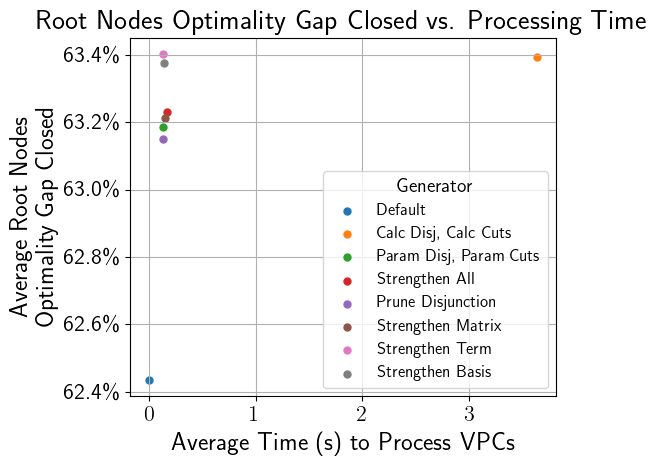

In [202]:
# again nearly pareto optimal - time and strength both ordered in terms of doing more "work". Makes sense for matrix case compared to 
make_pareto_frontier(bound_df)

## High Performing Root Stats

In [78]:
# # example table for VPC strength
# out.loc[out["degree"] != 16, ["degree", "terms", "perturbation"] + [c for c in out.columns if "VPCs" in c and "No" not in c]]

In [79]:
# # example table for root cut strength
# out.loc[out["degree"] != 16, ["degree", "terms", "perturbation"] + [c for c in out.columns if "Root Cuts" in c and ("No" not in c or "None" in c)]]

In [80]:
# # example table for root cut generation time
# out.loc[out["degree"] != 16, ["degree", "terms", "perturbation"] + [c for c in out.columns if "rootDualBoundTime" in c and ("No" not in c or "None" in c)]]

## Check Termination Stats

In [ ]:
# only check perturbed instances that solve to optimality and VPC didn't find optimal solution
mask = (
    (df["Disjunction (New)"] < 0.9999) & (df["instanceIndex"] > 0)
    & np.logical_and.reduce([optimality_gap(df, gen) <= 1e-4 for gen in generators])
    & (df["terminationTime None"] > min_termination_time)
)
# if remove_status_changes:
#     mask = mask & (df["infeasibleToFeasibleTermsRatio Farkas"] == 0) & (df["feasibleToInfeasibleTermsRatio Farkas"] == 0)

gap_df = df.loc[mask]

In [188]:
def plot_distributions(histogram_df, feature, bins=100, xlim=(-2, 1), ylim=(0, 1), perturbation=None, exclude_perturbation=False, title_x=.5, relative=True):
    """
    Generate a grid of cumulative distribution functions (CDFs) for a given feature,
    one for each combination of terms and degrees.
    """

    unique_degrees = histogram_df['degree'].sort_values(ascending=False).unique()
    unique_terms = histogram_df['terms'].sort_values().unique()

    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(6 * len(unique_terms), 6 * len(unique_degrees)))
    
    compare_gens = [gen for gen in generators if gen != "None" and gen != "New"]

    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j] if len(unique_degrees) > 1 and len(unique_terms) > 1 else axes[i] if len(unique_degrees) > 1 \
                else axes[j] if len(unique_terms) > 1 else axes

            subset_df = histogram_df[(histogram_df['degree'] == degree) & (histogram_df['terms'] == terms)]

            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation] if not exclude_perturbation \
                    else subset_df[subset_df["perturbation"] != perturbation]

            # Compute relative improvements dynamically from generators
            relative_improvements = {gen: subset_df[f"{feature} {gen}"] for gen in compare_gens} if not relative else \
                {gen: -(subset_df[f"{feature} None"] - subset_df[f"{feature} {gen}"]) / subset_df[f"{feature} None"] for gen in compare_gens}

            x = np.linspace(xlim[0], xlim[1], bins)

            # Compute CDFs
            cdfs = {
                gen: np.array([(ri <= val).sum() / len(ri) for val in x])
                for gen, ri in relative_improvements.items()
            }

            # Plot each generator's CDF with distinct color
            cmap = plt.get_cmap("tab10")
            for idx, gen in enumerate(compare_gens):
                ax.plot(x, cdfs[gen], label=cat_map.get(gen, gen), color=cmap(idx))

            # Optionally fill region where first generator dominates all others
            primary = "Farkas"
            others = [g for g in compare_gens if g != "Farkas"]
            fill_region = [max(cdfs[gen][k] for gen in others) > cdfs[primary][k] for k in range(len(x))]
            ax.fill_between(x, cdfs[primary], np.maximum.reduce([cdfs[gen] for gen in others]),
                            where=fill_region,
                            facecolor='yellow', alpha=0.7,
                            label=f'Improvement over\n{cat_map.get(primary, primary)}')

            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_title(f"{degree} Degree{'s' if degree > 1 else ''}, {terms} Terms")
            if j == 0:
                ax.set_ylabel("Probability")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel("Relative Change")

    # Shared legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(title_x, -0.05), ncol=5)

    fig.suptitle(f"CDF of {'Relative Change in ' if relative else ''}Solve {label[feature]}"
                 f"{' for ' + (perturbation.title() if perturbation != 'rhs' else perturbation.upper()) + ' Perturbations' if perturbation else ''}", x=title_x)
    plt.tight_layout()

    plt.savefig(os.path.join(out_fldr, f"cdf_{feature}{'_' + perturbation if perturbation else ''}{'_relative_improvements' if relative else ''}.png"), dpi=1200, bbox_inches='tight')
    plt.show()


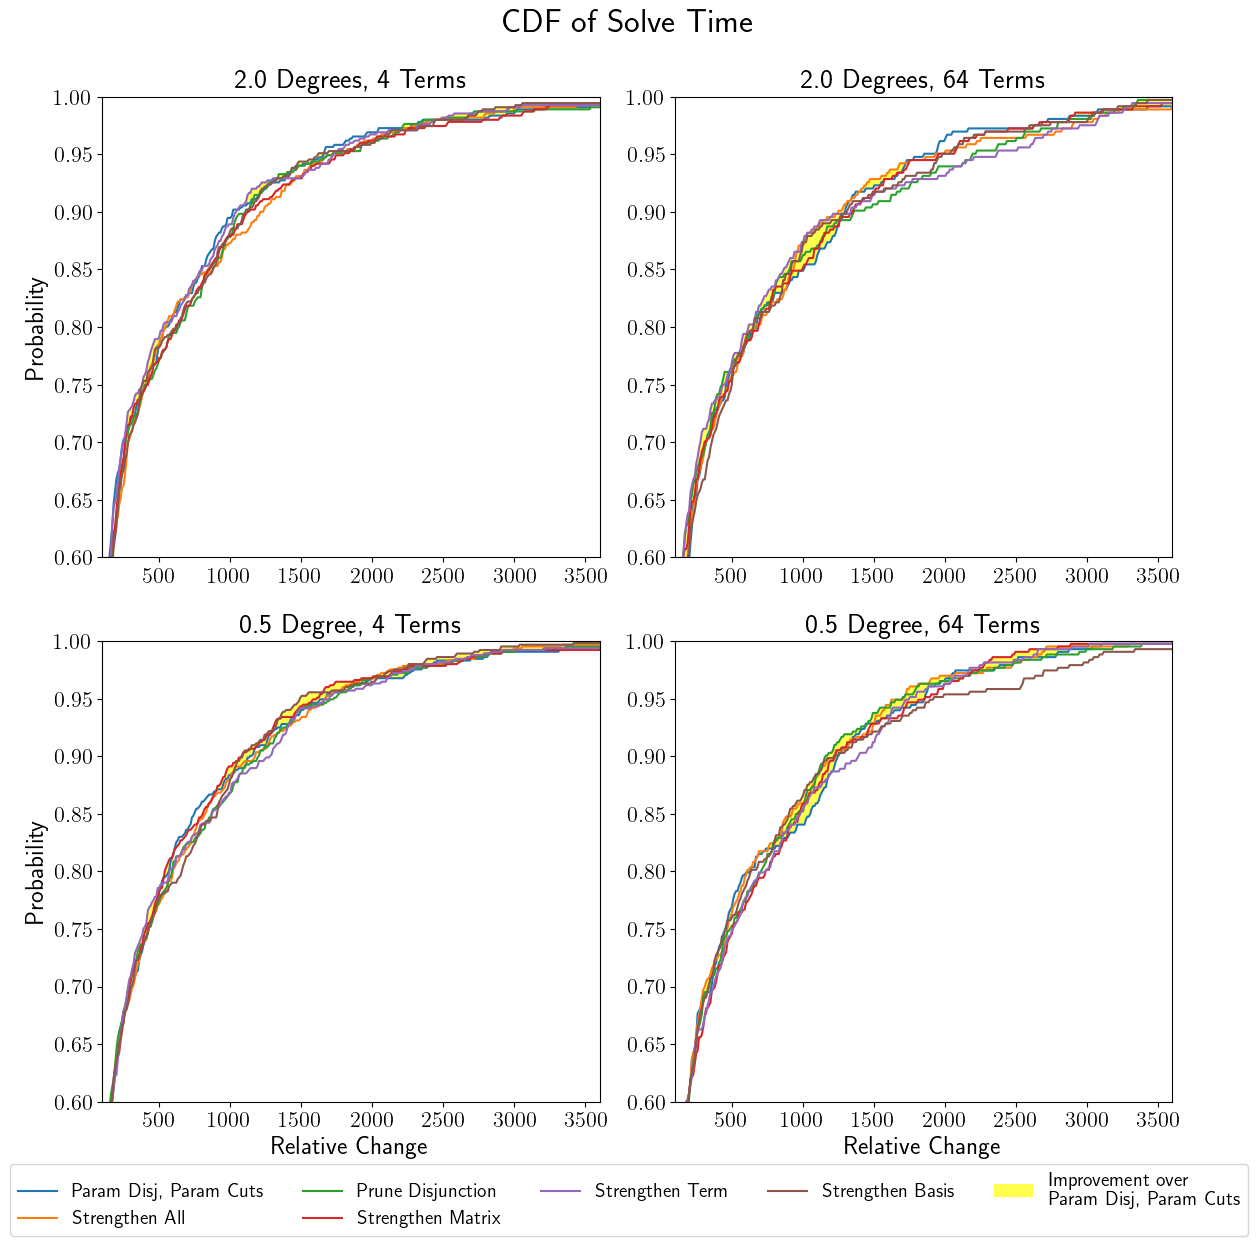

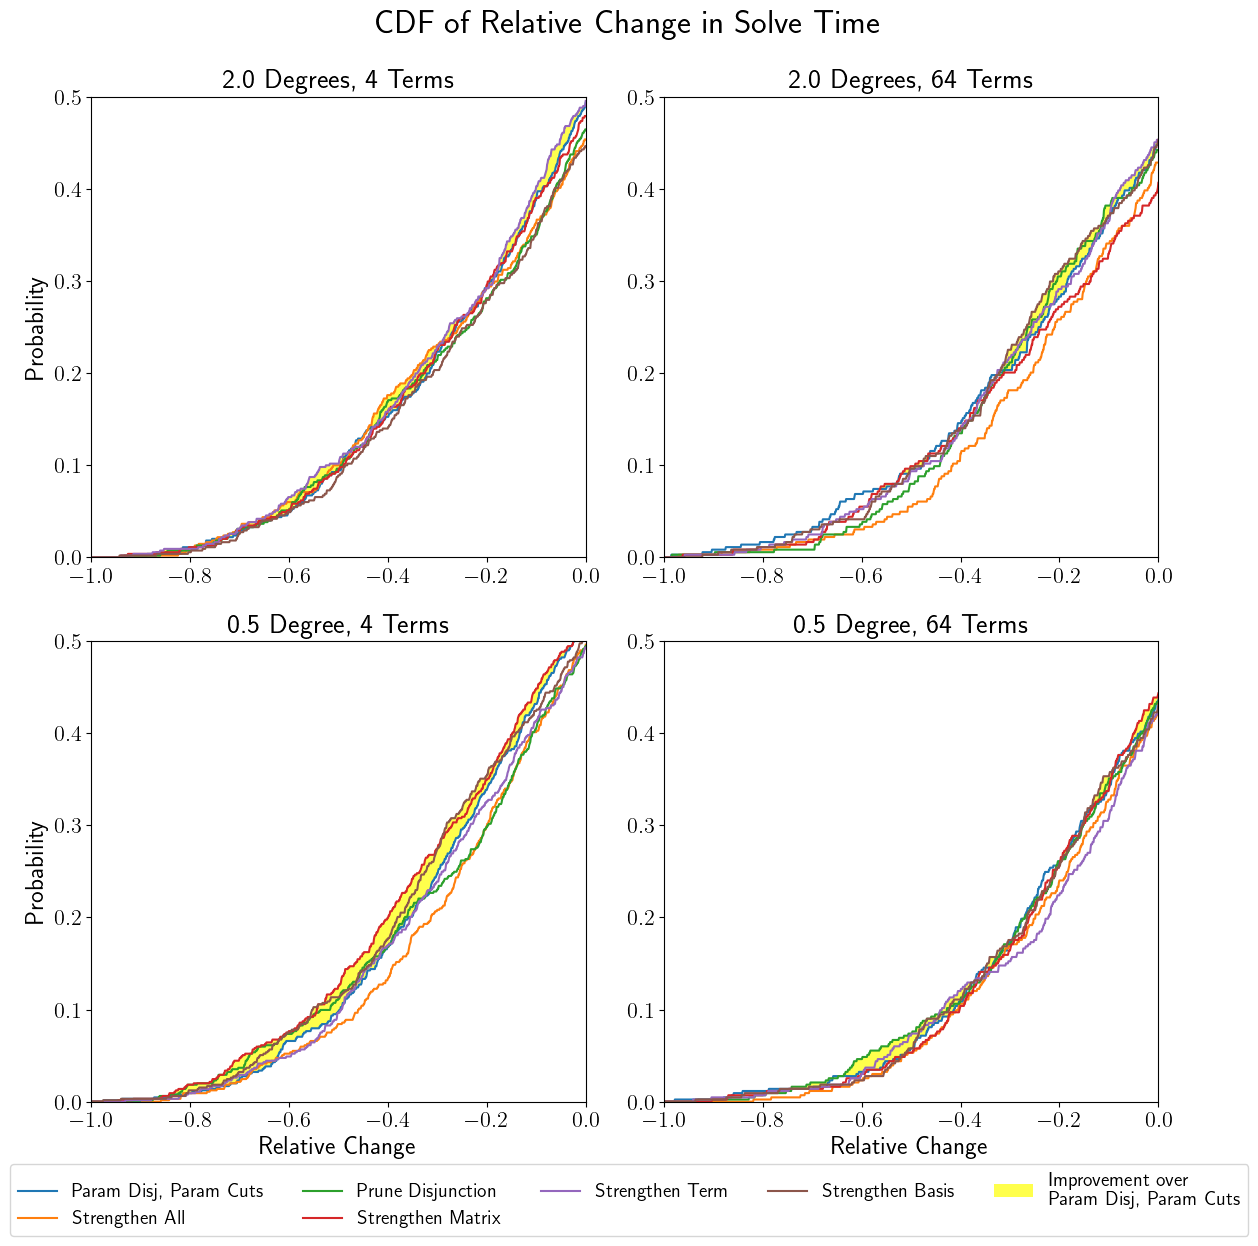

In [184]:
plot_distributions(gap_df, "terminationTime", xlim=(100, 3600), ylim=(.6, 1), bins=350, title_x=.525, relative=False)
plot_distributions(gap_df, "terminationTime", xlim=(-1, 0), ylim=(0, .5), bins=1000, title_x=.525, relative=True)

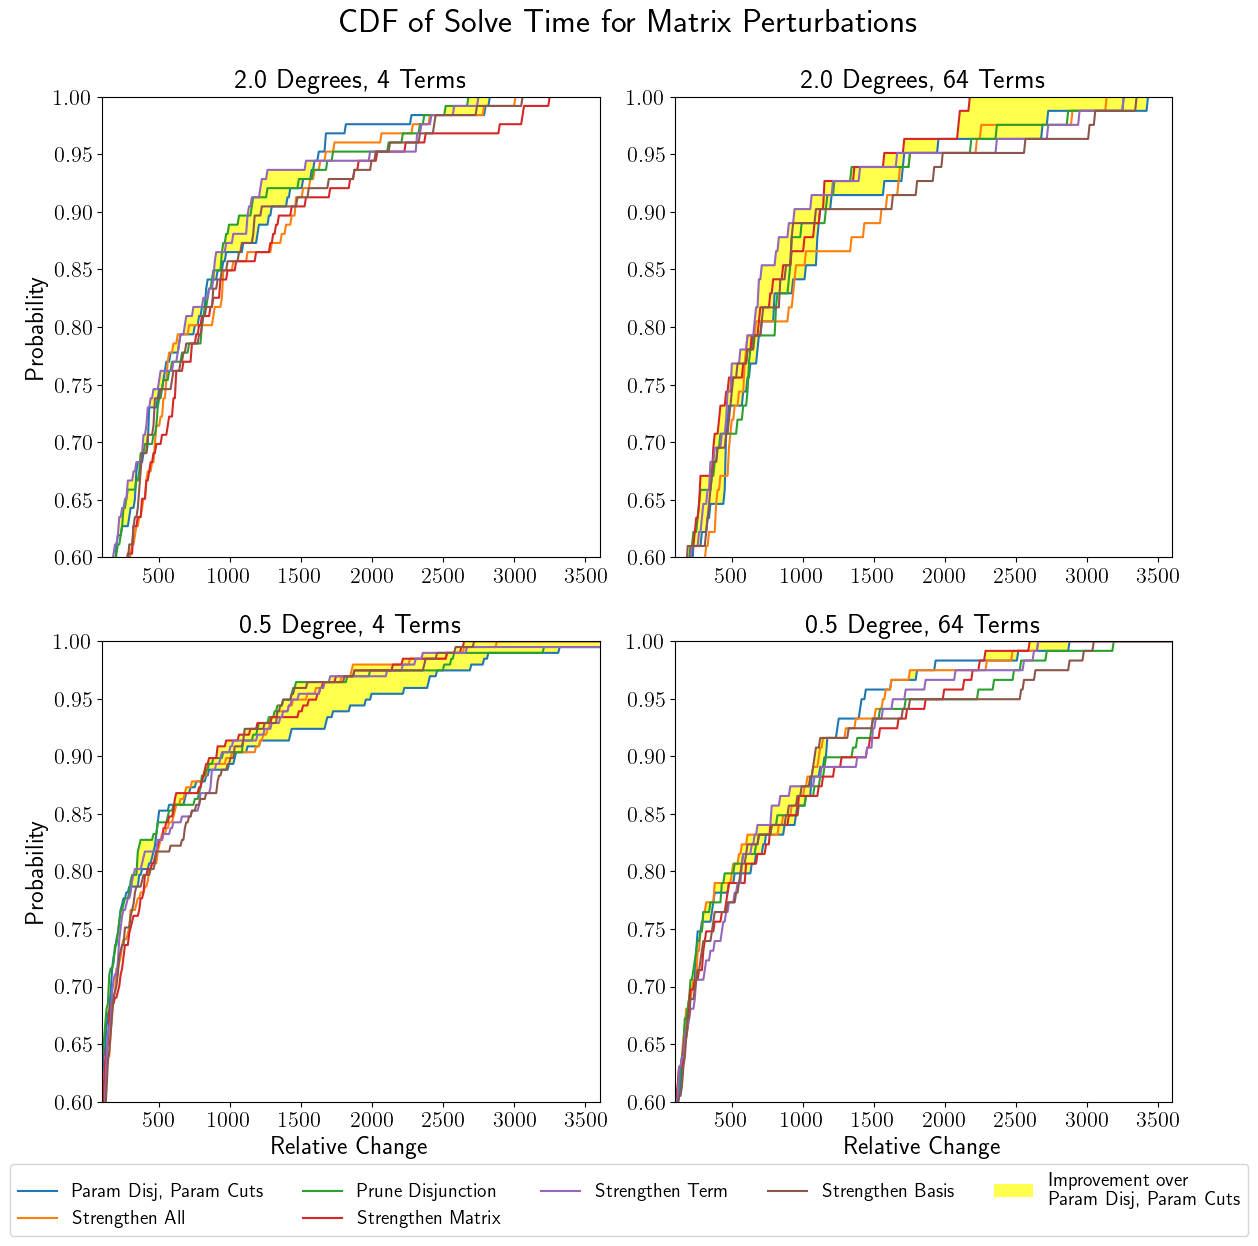

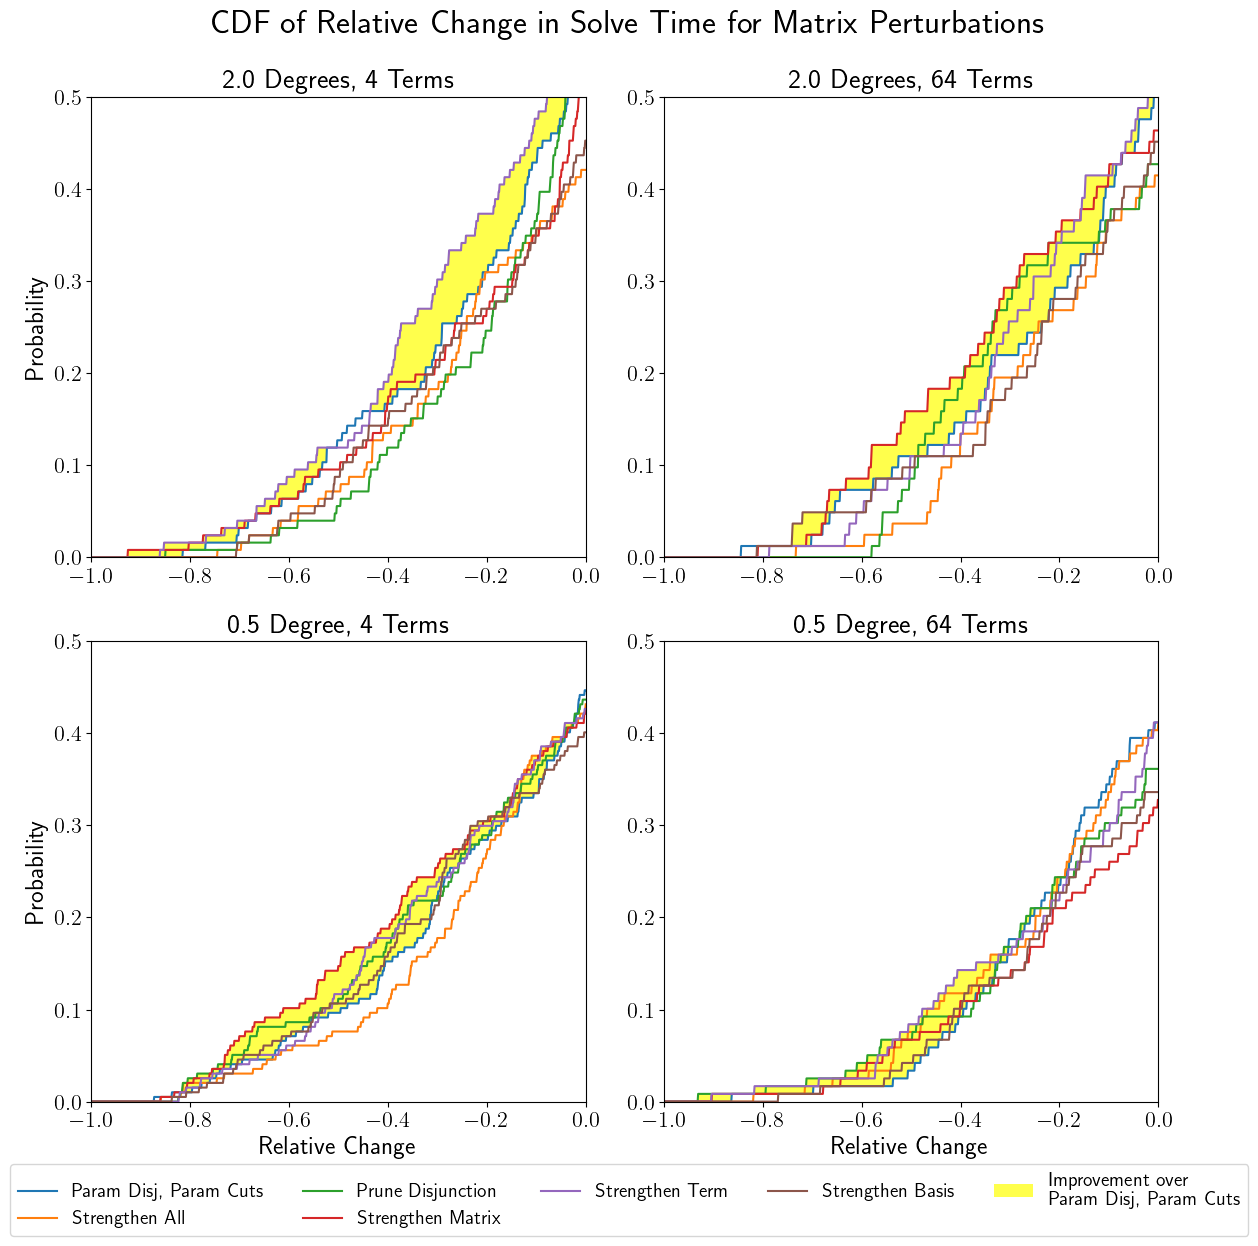

In [185]:
plot_distributions(gap_df, "terminationTime", xlim=(100, 3600), ylim=(.6, 1), bins=350, title_x=.525, relative=False, perturbation="matrix")
plot_distributions(gap_df, "terminationTime", xlim=(-1, 0), ylim=(0, .5), bins=1000, title_x=.525, relative=True, perturbation="matrix")

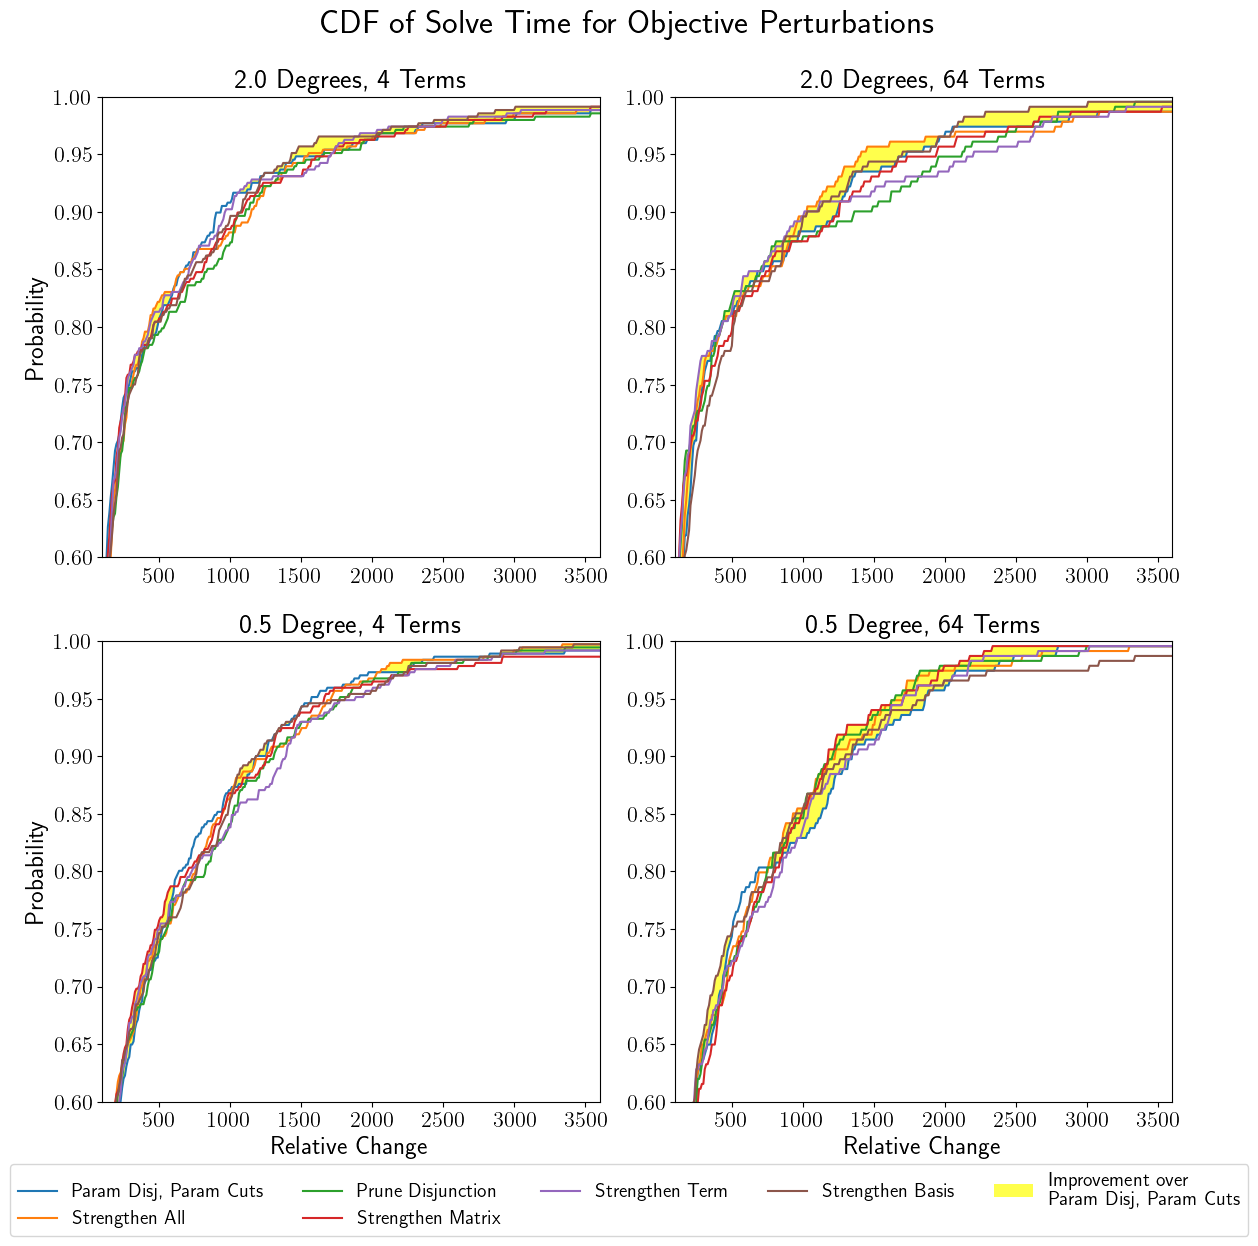

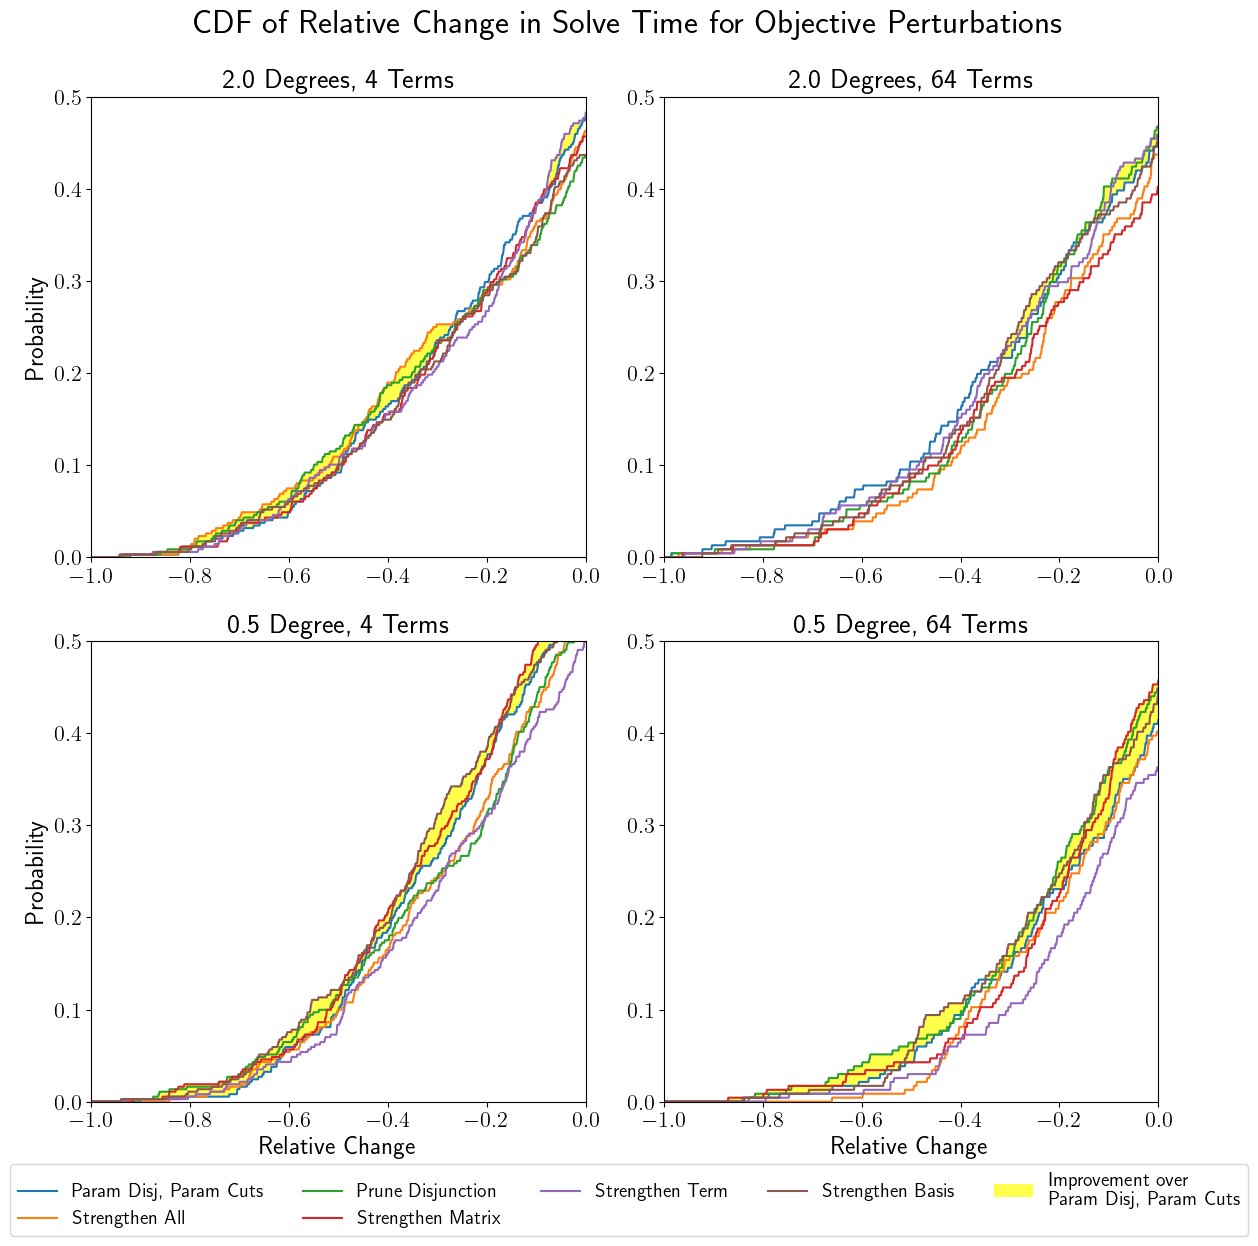

In [186]:
plot_distributions(gap_df, "terminationTime", xlim=(100, 3600), ylim=(.6, 1), bins=350, title_x=.525, relative=False, perturbation="objective")
plot_distributions(gap_df, "terminationTime", xlim=(-1, 0), ylim=(0, .5), bins=1000, title_x=.525, relative=True, perturbation="objective")

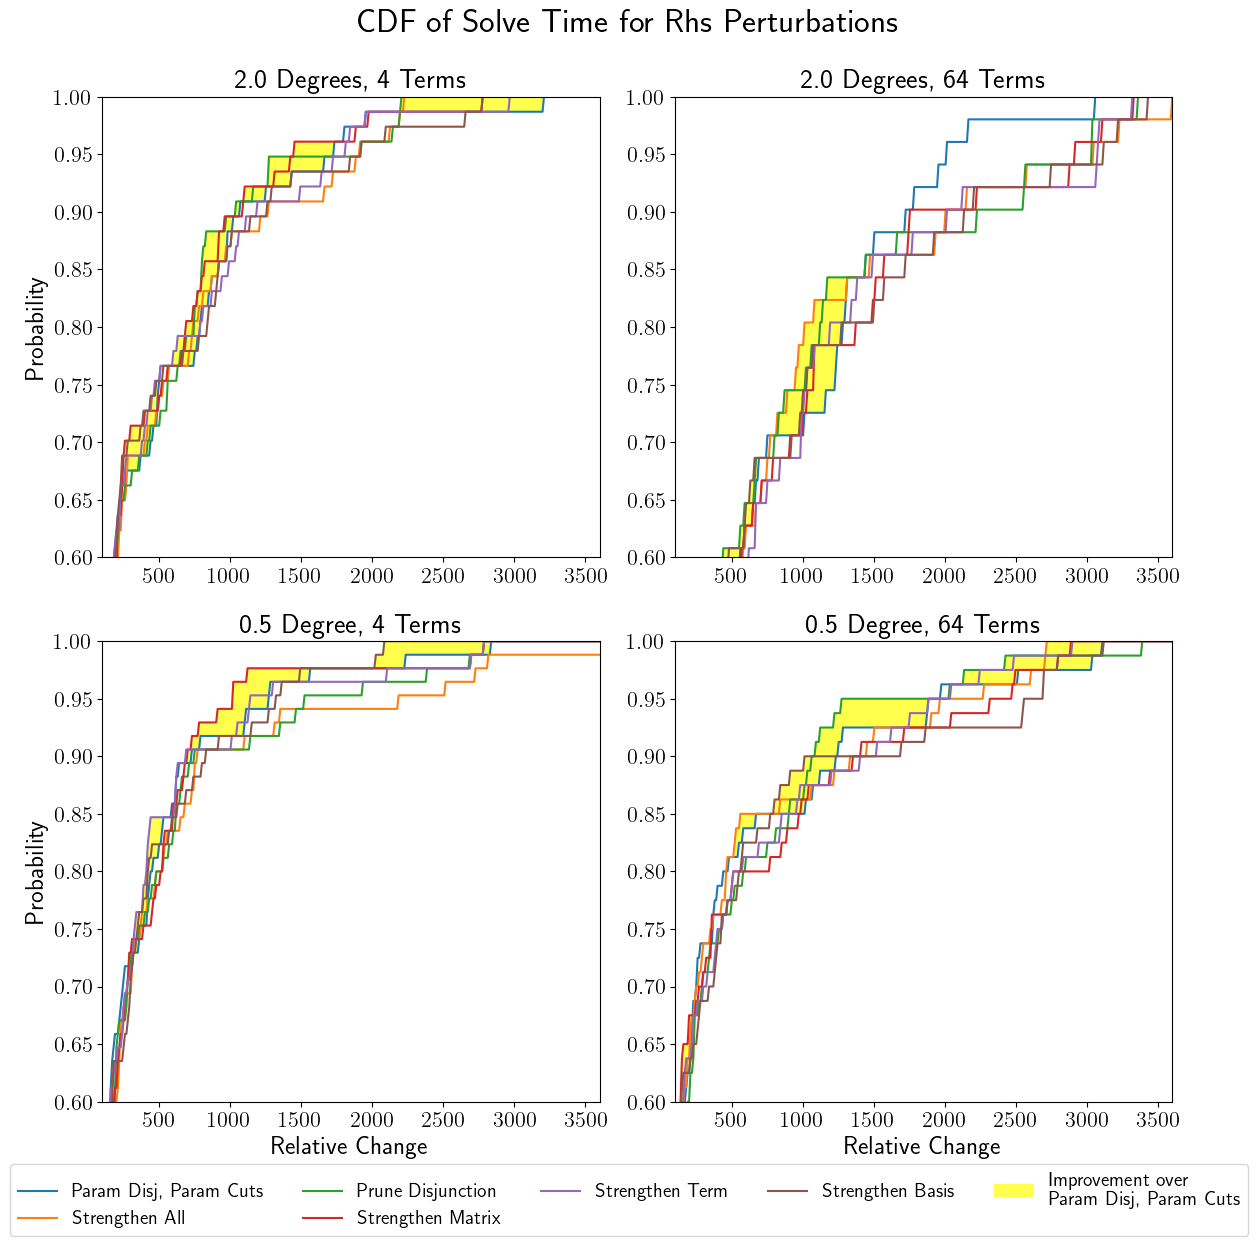

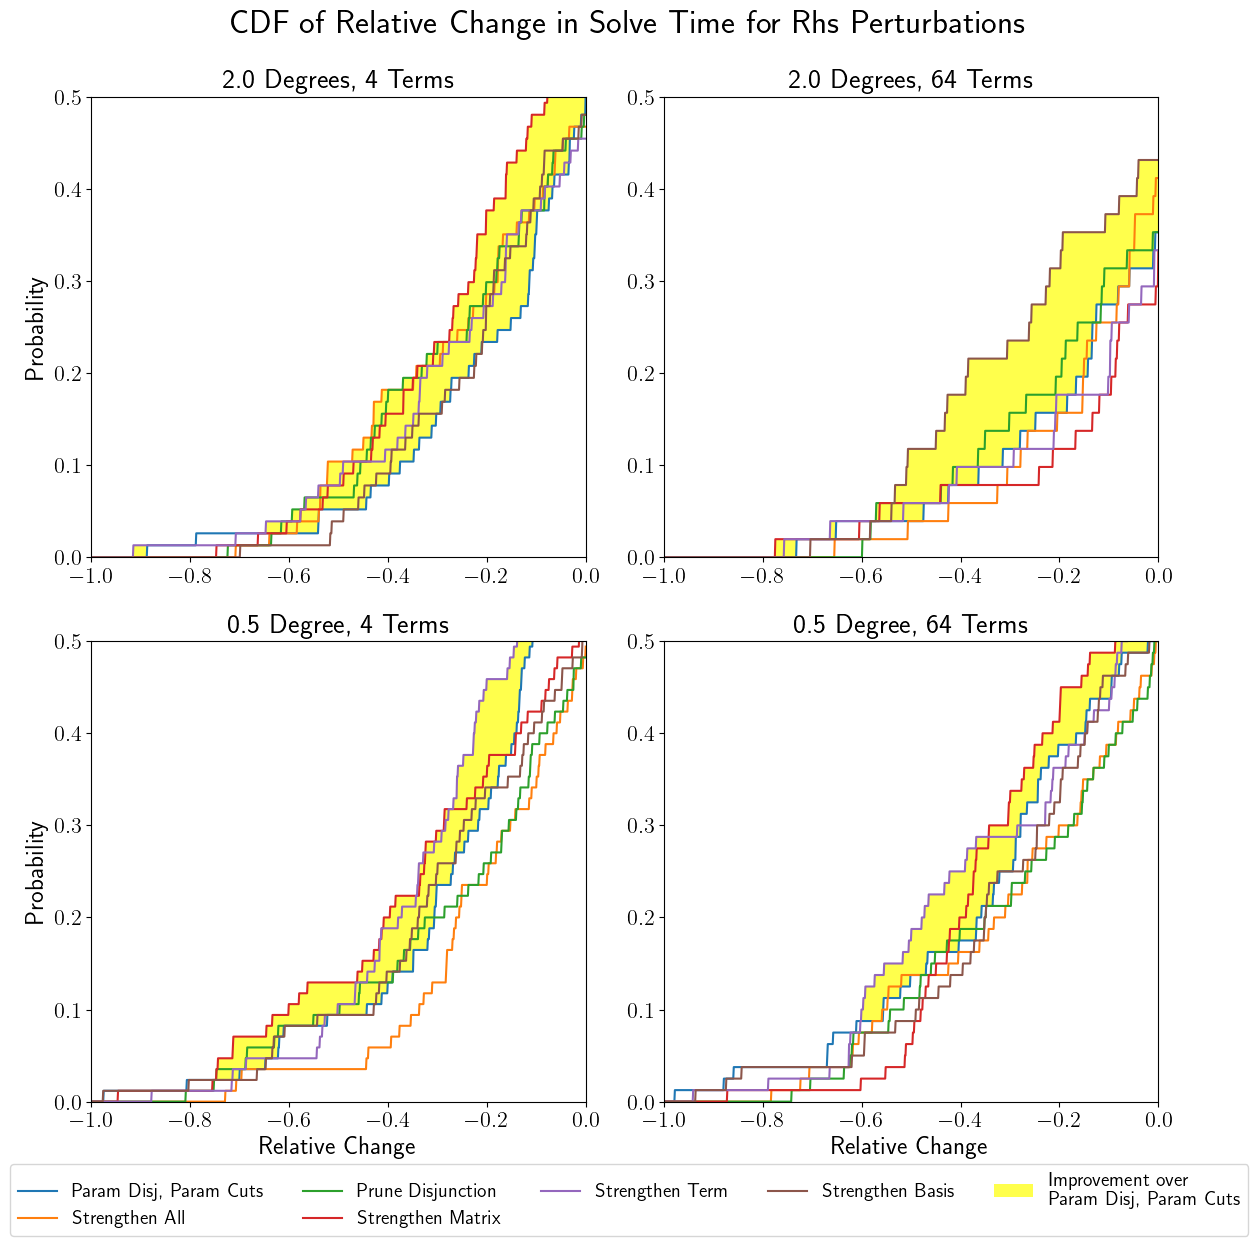

In [187]:
plot_distributions(gap_df, "terminationTime", xlim=(100, 3600), ylim=(.6, 1), bins=350, title_x=.525, relative=False, perturbation="rhs")
plot_distributions(gap_df, "terminationTime", xlim=(-1, 0), ylim=(0, .5), bins=1000, title_x=.525, relative=True, perturbation="rhs")

In [82]:
def rename_cols(cols, feature):
    new_cols = []
    for col in cols:
        if f"{feature}Win" in col:
            col = col.replace(f"{feature}Win", f"{label[feature]} Win % ")
        elif "instanceIndex" in col:
            col = col.replace("instanceIndex", "Test Instances")
        elif "instance" in col:
            col = col.replace("instance", "Base Instances")
        new_cols.append(col)
    return new_cols

In [86]:
def get_wins(feature, grouping):
    """
    
    :param feature: "nodes", "terminationTime", "terminationTimeSansVpc"
    :param grouping: "perturbation", "terms", "bracket", "degree" 
    :return: 
    """

    # get the win percentages for each feature on average and broken down by grouping type
    features = [feature]
    keys = []    
    wins = {}
    
    for feature in features:
        
        # define aggregating operations
        aggregations = {f"{feature}Win{gen}": "mean" for gen in generators + ["Any"]}
        if feature == features[-1]:
            aggregations = aggregations | {"instance": "nunique", "instanceIndex": "count"}
        
        # find the average wins for the feature grouped by degree and terms
        feature_wins = gap_df[gap_df["perturbation"] != "bound"].groupby(keys + [grouping]).agg(aggregations)
        
        # clean up formatting
        feature_wins.columns = rename_cols(feature_wins.columns, feature)
        win_cols = [c for c in feature_wins.columns if "Win" in c]
        feature_wins[win_cols] = feature_wins[win_cols].applymap(lambda x: round(x * 100, 2))
        instance_cols = [c for c in feature_wins.columns if "instance" in c]
        feature_wins[instance_cols] = feature_wins[instance_cols].applymap(lambda x: int(x))
        
        # save the df
        wins[feature] = feature_wins
        
    # bring them all together now
    all_wins = pd.concat(wins.values(), axis=1).sort_values(keys + [grouping], ascending=[c != "bracket" for c in keys + [grouping]]).reset_index()
    all_wins.to_csv(os.path.join(out_fldr, f"branch_and_bound_wins_{feature}_{grouping}.csv"), index=False, mode="w")
    all_wins
    return all_wins

In [87]:
get_wins("nodes", "degree")

,degree,Nodes Processed Win % None,Nodes Processed Win % New,Nodes Processed Win % Farkas,Nodes Processed Win % All,Nodes Processed Win % Disjunction,Nodes Processed Win % Matrix,Nodes Processed Win % Term,Nodes Processed Win % Basis,Nodes Processed Win % Any,Base Instances,Test Instances
0,0.5,7.18,5.99,6.26,4.24,4.51,4.05,3.13,4.97,68.97,105,1086
1,2.0,6.89,8.31,5.25,5.57,5.79,4.04,4.15,3.93,70.93,106,915


In [88]:
get_wins("terminationTime", "degree")

,degree,Time Win % None,Time Win % New,Time Win % Farkas,Time Win % All,Time Win % Disjunction,Time Win % Matrix,Time Win % Term,Time Win % Basis,Time Win % Any,Base Instances,Test Instances
0,0.5,11.97,3.96,8.10,5.80,7.55,7.00,4.70,7.00,75.05,105,1086
1,2.0,12.24,6.78,5.57,6.01,5.14,4.81,6.34,7.54,73.11,106,915


In [89]:
get_wins("nodes", "terms")

,terms,Nodes Processed Win % None,Nodes Processed Win % New,Nodes Processed Win % Farkas,Nodes Processed Win % All,Nodes Processed Win % Disjunction,Nodes Processed Win % Matrix,Nodes Processed Win % Term,Nodes Processed Win % Basis,Nodes Processed Win % Any,Base Instances,Test Instances
0,4,6.98,6.98,5.73,4.57,5.48,4.15,2.91,4.07,70.18,114,1204
1,64,7.15,7.15,5.90,5.27,4.52,3.89,4.64,5.14,69.39,89,797


In [91]:
get_wins("terminationTime", "terms")

,terms,Time Win % None,Time Win % New,Time Win % Farkas,Time Win % All,Time Win % Disjunction,Time Win % Matrix,Time Win % Term,Time Win % Basis,Time Win % Any,Base Instances,Test Instances
0,4,9.88,7.14,7.23,5.9,6.31,6.64,5.40,5.48,77.49,114,1204
1,64,15.43,2.38,6.52,5.9,6.65,5.02,5.52,9.91,69.13,89,797


In [92]:
get_wins("nodes", "bracket")

,bracket,Nodes Processed Win % None,Nodes Processed Win % New,Nodes Processed Win % Farkas,Nodes Processed Win % All,Nodes Processed Win % Disjunction,Nodes Processed Win % Matrix,Nodes Processed Win % Term,Nodes Processed Win % Basis,Nodes Processed Win % Any,Base Instances,Test Instances
0,short,9.07,6.67,7.47,4.67,5.33,3.47,3.60,3.47,66.93,93,750
1,medium,7.06,6.71,4.82,4.94,5.65,4.24,3.76,3.88,70.94,87,850
2,long,3.24,8.48,4.74,4.99,3.49,4.74,3.24,7.73,73.07,52,401


In [93]:
get_wins("terminationTime", "bracket")

,bracket,Time Win % None,Time Win % New,Time Win % Farkas,Time Win % All,Time Win % Disjunction,Time Win % Matrix,Time Win % Term,Time Win % Basis,Time Win % Any,Base Instances,Test Instances
0,short,17.47,3.07,8.27,5.60,6.00,4.93,4.93,7.20,67.20,93,750
1,medium,10.12,5.76,6.35,6.00,7.65,6.24,5.76,6.71,76.35,87,850
2,long,6.23,8.23,5.74,6.23,4.74,7.48,5.74,8.48,82.54,52,401


In [94]:
get_wins("nodes", "perturbation")

,perturbation,Nodes Processed Win % None,Nodes Processed Win % New,Nodes Processed Win % Farkas,Nodes Processed Win % All,Nodes Processed Win % Disjunction,Nodes Processed Win % Matrix,Nodes Processed Win % Term,Nodes Processed Win % Basis,Nodes Processed Win % Any,Base Instances,Test Instances
0,matrix,7.25,6.11,6.68,5.15,4.01,5.53,4.58,3.05,69.85,88,524
1,objective,6.67,7.77,5.07,4.81,5.66,3.63,2.87,5.24,70.02,88,1184
2,rhs,8.19,5.80,7.17,4.44,4.78,3.07,4.78,4.10,69.28,58,293


In [95]:
get_wins("terminationTime", "perturbation")

,perturbation,Time Win % None,Time Win % New,Time Win % Farkas,Time Win % All,Time Win % Disjunction,Time Win % Matrix,Time Win % Term,Time Win % Basis,Time Win % Any,Base Instances,Test Instances
0,matrix,13.93,6.49,8.21,5.15,7.06,6.68,7.82,5.15,71.95,88,524
1,objective,11.66,5.07,6.25,6.42,6.84,5.32,3.72,7.69,74.58,88,1184
2,rhs,10.58,3.75,7.51,5.12,3.75,7.51,8.19,9.22,76.45,58,293


In [84]:
def aggregate_wins(gap_df, feature, grouping):

    def custom_key(col):
        # bump improvement columns second to win percentage columns
        offset = int("Improvement %" in col)
        # check groupings
        if 'matrix' in col or 'short' in col:
            return (2 + offset, col)
        elif 'objective' in col or 'medium' in col:
            return (4 + offset, col)
        elif 'rhs' in col or 'long' in col:
            return (6 + offset, col)    
        return (offset, col)
    
    # find the average wins for the feature grouped by degree, terms and grouping type
    win_aggregations = {f"{feature}Win{gen}": "mean" for gen in generators + ["Any"]}
    feature_wins = gap_df[gap_df["perturbation"] != "bound"].groupby(["degree", "terms", grouping]).agg(win_aggregations).reset_index().pivot(
        index=['degree', 'terms'], columns=grouping, values=[f"{feature}Win{gen}" for gen in generators + ["Any"]]
    )
    feature_wins.columns = rename_cols([' '.join(col).strip() for col in feature_wins.columns.values], feature)
    feature_wins = feature_wins[sorted(feature_wins.columns, key=custom_key)]
    feature_wins = feature_wins.applymap(lambda x: round(x * 100, 2))
    
    # get the counts for the feature grouped by degree, terms and grouping type
    count_aggregations = {"instance": "nunique", "instanceIndex": "count"}
    feature_counts = gap_df[gap_df["perturbation"] != "bound"].groupby(["degree", "terms", grouping]).agg(count_aggregations).reset_index().pivot(
        index=['degree', 'terms'], columns=grouping, values=["instance", "instanceIndex"]
    )
    feature_counts.columns = rename_cols([' '.join(col).strip() for col in feature_counts.columns.values], feature)
    feature_counts = feature_counts[sorted(feature_counts.columns, key=custom_key)]
    feature_counts = feature_counts.applymap(lambda x: int(x))
    
    # save wins, base instance counts, and test instance counts to csv
    feature_wins.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_wins_{feature}_{grouping}.csv"), index=False, mode="w")
    feature_counts.reset_index().to_csv(os.path.join(out_fldr, f"branch_and_bound_counts_{grouping}.csv"), index=False, mode="w")
    
    return feature_wins, feature_counts

In [84]:
# wins, counts = aggregate_wins(gap_df, "terminationTime", "bracket")
# wins

Time Win % All short  Time Win % Any short  \
degree terms                                               
0.5    4                      5.30                 70.02   
       64                     5.09                 54.96   
2.0    4                      7.91                 69.57   
       64                     3.09                 48.60   

              Time Win % Basis short  Time Win % Disjunction short  \
degree terms                                                         
0.5    4                        5.85                          6.58   
       64                       6.62                          5.34   
2.0    4                        4.46                          3.65   
       64                       7.87                          4.49   

              Time Win % Farkas short  Time Win % Matrix short  \
degree terms                                                     
0.5    4                         6.22                     6.76   
       64                        6.36                     6.62   
2.0    4                         7.51                     4.67   
       64                        3.65                     3.65   

              Time Win % New short  Time Win % None short  \
degree terms                                                
0.5    4                      1.83                  12.80   
       64                     0.76                  25.45   
2.0    4                      2.43                  16.43   
       64                     0.00                  35.67   

              Time Win % Term short  Time Win % All medium  ...  \
degree terms                                                ...   
0.5    4                       4.20                   4.17  ...   
       64                      4.58                   8.20  ...   
2.0    4                       5.07                   7.85  ...   
       64                      5.90                   3.73  ...   

              Time Win % Term medium  Time Win % All long  \
degree terms                                                
0.5    4                        7.20                 8.76   
       64                       3.83                 3.80   
2.0    4                        6.20                 4.55   
       64                       4.97                 6.67   

              Time Win % Any long  Time Win % Basis long  \
degree terms                                               
0.5    4                    85.40                   7.30   
       64                   79.75                   5.06   
2.0    4                    82.73                  10.91   
       64                   80.00                  10.67   

              Time Win % Disjunction long  Time Win % Farkas long  \
degree terms                                                        
0.5    4                             2.19                    9.49   
       64                            6.33                    3.80   
2.0    4                             5.45                    2.73   
       64                            6.67                    5.33   

              Time Win % Matrix long  Time Win % New long  \
degree terms                                                
0.5    4                       10.95                 8.03   
       64                       5.06                 5.06   
2.0    4                        5.45                13.64   
       64                       6.67                 4.00   

              Time Win % None long  Time Win % Term long  
degree terms                                              
0.5    4                      6.57                  2.92  
       64                     8.86                  6.33  
2.0    4                      0.91                  9.09  
       64                    10.67                  5.33  

[4 rows x 27 columns]

In [86]:
# wins, counts = aggregate_wins(gap_df, "terminationTime", "perturbation")
# wins

Time Win % All matrix  Time Win % Any matrix  \
degree terms                                                 
0.5    4                       4.64                  73.93   
       64                      6.95                  54.01   
2.0    4                       4.88                  75.61   
       64                      4.23                  57.75   

              Time Win % Basis matrix  Time Win % Disjunction matrix  \
degree terms                                                           
0.5    4                         5.36                           8.57   
       64                        4.28                           6.42   
2.0    4                         3.90                           3.90   
       64                        9.15                           4.23   

              Time Win % Farkas matrix  Time Win % Matrix matrix  \
degree terms                                                       
0.5    4                          9.64                      4.29   
       64                         4.28                      2.14   
2.0    4                          8.78                      9.27   
       64                         4.23                     10.56   

              Time Win % New matrix  Time Win % None matrix  \
degree terms                                                  
0.5    4                       3.93                   12.14   
       64                      4.28                   27.81   
2.0    4                       5.37                   10.73   
       64                      2.82                   30.28   

              Time Win % Term matrix  Time Win % All objective  ...  \
degree terms                                                    ...   
0.5    4                        7.50                      6.53  ...   
       64                       4.28                      4.76  ...   
2.0    4                        9.27                      7.99  ...   
       64                       8.45                      4.02  ...   

              Time Win % Term objective  Time Win % All rhs  \
degree terms                                                  
0.5    4                           3.07                3.40   
       64                          3.27                6.82   
2.0    4                           4.68                9.45   
       64                          5.17                1.96   

              Time Win % Any rhs  Time Win % Basis rhs  \
degree terms                                             
0.5    4                   80.95                  4.76   
       64                  68.18                  8.33   
2.0    4                   78.74                  6.30   
       64                  49.02                 14.71   

              Time Win % Disjunction rhs  Time Win % Farkas rhs  \
degree terms                                                      
0.5    4                            6.80                   4.76   
       64                           3.03                  10.61   
2.0    4                            3.15                   5.51   
       64                           2.94                   1.96   

              Time Win % Matrix rhs  Time Win % New rhs  Time Win % None rhs  \
degree terms                                                                   
0.5    4                       8.16                2.72                 8.84   
       64                      6.82                0.76                13.64   
2.0    4                       7.09                3.94                 7.87   
       64                      0.98                1.96                31.37   

              Time Win % Term rhs  
degree terms                       
0.5    4                     6.12  
       64                    8.33  
2.0    4                     5.51  
       64                    2.94  

[4 rows x 27 columns]

## High Performing Run Time Subset

In [80]:
# additional filtering for dataframe on run time
fields = [f"terminationTime {gen}" for gen in generators] + \
         [f"terminationTimeImprovement {gen}" for gen in generators if gen not in ["None", "New"]]
# only check perturbed instances that solve to optimality and VPC didn't find optimal solution
mask = (
    (df["Disjunction (New)"] < 0.9999) & (df["instanceIndex"] > 0)
    & np.logical_and.reduce([optimality_gap(df, gen) <= 1e-4 for gen in generators])
    & (df["terminationTime None"] > min_termination_time)
)

# create time dataframe
time_df = df.loc[mask, group_cols + id_cols + fields]

In [79]:
aggregations = {f"Average Time {gen}": (f"terminationTime {gen}", geometric_mean) for gen in generators} | \
    {f"Average Improvement {gen}": (f"terminationTimeImprovement {gen}", "mean") for gen in generators if gen not in ["None", "New"]} | \
    {"count": ("terminationTimeImprovement Farkas", "size")}

tmp = time_df.groupby(["instance", "perturbation", "degree", "terms"]).agg(**aggregations).reset_index()
tmp = tmp[(tmp["count"] > 1)]
tmp.to_csv(os.path.join(out_fldr, "high_perform_all.csv"), index=False, mode="w")
tmp.head()

,instance,perturbation,degree,terms,Average Time None,Average Time New,Average Time Farkas,Average Time All,Average Time Disjunction,Average Time Matrix,Average Time Term,Average Time Basis,Average Improvement Farkas,Average Improvement All,Average Improvement Disjunction,Average Improvement Matrix,Average Improvement Term,Average Improvement Basis,count
0,aflow30a,matrix,1,4,3.397194,6.908022,3.193351,2.461512,3.536989,3.335433,2.450183,2.442320,-0.014592,0.244497,-0.192570,-0.114798,0.221280,0.223497,9
1,aflow30a,matrix,1,64,5.262113,8.670610,5.423080,5.206116,4.875512,4.878356,4.999452,4.997785,-0.143554,-0.123315,-0.052529,-0.051905,-0.029195,-0.028607,8
2,aflow30a,rhs,1,4,2.071641,8.422406,2.870855,2.752171,2.240980,2.532260,2.320147,2.639981,-0.420380,-0.489788,-0.205667,-0.278145,-0.124080,-0.288904,3
3,aflow30a,rhs,1,64,3.124030,7.635770,3.190507,3.526027,3.366901,2.722832,2.450773,4.550764,-0.056778,-0.207908,-0.272866,0.085129,0.172113,-0.470320,3
4,aligninq,matrix,1,4,129.830683,130.857454,123.017751,113.325551,126.388712,126.584325,102.625044,126.977951,-0.113077,-0.018756,-0.076447,-0.078747,0.158329,-0.087549,10


In [80]:
def make_improvement_table(tmp, generator):
    
    # columns we always choose
    key_cols = ["degree", "terms", "perturbation", "instance"]
    time_cols = [f"Average Time {g}" for g in ["None", "New", "Farkas"]]
    
    # subset the ones we want
    all_df = tmp[
        key_cols + time_cols + [f"Average Time {generator}", f"Average Improvement Farkas", f"Average Improvement {generator}", "count"]
    ].sort_values(f"Average Improvement {generator}", ascending=False)
    all_df = all_df[all_df[f"Average Improvement {generator}"] > 0]
    best_df = all_df.loc[
        all_df.groupby(['perturbation', 'degree', 'terms'])[f'Average Improvement {generator}'].idxmax()
    ].sort_values(f"Average Improvement {generator}", ascending=False)
    
    # save all the winners
    all_df.to_csv(os.path.join(out_fldr, f"high_perform_{generator.lower()}.csv"), index=False, mode="w")
    
    # return just the best
    return all_df, best_df

In [81]:
all_df, best_df = make_improvement_table(tmp, "Disjunction")
best_df.loc[[285, 392, 213, 373, 186, 172], [c for c in best_df.columns if "Improvement" not in c]]

,degree,terms,perturbation,instance,Average Time None,Average Time New,Average Time Farkas,Average Time Disjunction,count
285,1,4,matrix,neos-860300,129.235105,97.853468,70.466980,40.607542,10
392,1,4,objective,ran13x13,35.537751,14.976852,17.016891,13.095101,10
213,4,4,rhs,neos-3046615-murg,231.783260,168.801212,200.152352,150.464393,2
373,4,64,rhs,pg5_34,3.150931,71.660436,2.063292,1.944108,8
186,16,4,matrix,n7-3,8.888611,30.491732,13.156323,5.293075,2
172,16,64,objective,misc07,83.671824,47.174409,41.371435,28.676896,10


In [82]:
all_df, best_df = make_improvement_table(tmp, "Matrix")
best_df.loc[best_df["perturbation"] == "matrix", [c for c in best_df.columns if "Improvement" not in c]].sort_values(["degree", "terms"])

,degree,terms,perturbation,instance,Average Time None,Average Time New,Average Time Farkas,Average Time Matrix,count
285,1,4,matrix,neos-860300,129.235105,97.853468,70.466980,50.045030,10
388,1,64,matrix,ran13x13,22.612178,47.155872,20.394313,15.924265,10
332,4,4,matrix,neos18,5.268503,11.776036,4.612012,3.310361,9
75,4,64,matrix,g200x740,26.799084,62.360644,33.217829,20.611519,2
186,16,4,matrix,n7-3,8.888611,30.491732,13.156323,5.340057,2
296,16,64,matrix,neos-911970,29.294123,26.230940,26.757343,19.561260,6


In [83]:
all_df, best_df = make_improvement_table(tmp, "Term")
best_df = best_df.loc[(best_df["perturbation"] == "matrix") | (best_df["perturbation"] == "rhs"),
                      [c for c in best_df.columns if "Improvement" not in c]]
best_df.loc[[285, 373, 410, 296, 131, 341]].sort_values(["degree", "terms"])

,degree,terms,perturbation,instance,Average Time None,Average Time New,Average Time Farkas,Average Time Term,count
285,1,4,matrix,neos-860300,129.235105,97.853468,70.466980,39.316548,10
341,1,64,rhs,neos18,13.655170,638.616928,16.640351,9.637685,2
410,4,4,matrix,rout,10.085790,8.247897,10.493955,6.188331,10
373,4,64,rhs,pg5_34,3.150931,71.660436,2.063292,1.975149,8
131,16,4,rhs,mas76,47.049209,63.572653,44.410446,38.407041,4
296,16,64,matrix,neos-911970,29.294123,26.230940,26.757343,19.431839,6


In [84]:
all_df, best_df = make_improvement_table(tmp, "Basis")
best_df = best_df.loc[(best_df["perturbation"] == "matrix") | (best_df["perturbation"] == "rhs"),
                      [c for c in best_df.columns if "Improvement" not in c]]
best_df.loc[[285, 341, 195, 390, 296, 295]].sort_values(["degree", "terms"])

,degree,terms,perturbation,instance,Average Time None,Average Time New,Average Time Farkas,Average Time Basis,count
285,1,4,matrix,neos-860300,129.235105,97.853468,70.466980,37.981369,10
341,1,64,rhs,neos18,13.655170,638.616928,16.640351,9.832116,2
195,4,4,rhs,neos-1445743,43.887964,2706.963349,36.087721,24.296440,4
390,4,64,matrix,ran13x13,54.497417,66.367305,77.418971,42.131783,10
295,16,4,matrix,neos-911970,19.315416,18.745702,17.694233,10.563624,5
296,16,64,matrix,neos-911970,29.294123,26.230940,26.757343,16.078533,6


In [87]:
all_df, best_df = make_improvement_table(tmp, "All")
# swap 335 and 120 for poster vs paper
best_df.loc[[285, 335, 35, 390, 301, 172], [c for c in best_df.columns if "Improvement" not in c]].sort_values(["degree", "terms"])

,degree,terms,perturbation,instance,Average Time None,Average Time New,Average Time Farkas,Average Time All,count
285,1,4,matrix,neos-860300,129.235105,97.853468,70.466980,56.302859,10
335,1,64,objective,neos18,26.496431,51.959339,24.825103,20.318973,3
35,4,4,rhs,blp-ir98,12.691349,143.314590,8.665618,7.336168,2
390,4,64,matrix,ran13x13,54.497417,66.367305,77.418971,45.969478,10
301,16,4,objective,neos-911970,102.516404,69.198447,139.244088,41.855894,2
172,16,64,objective,misc07,83.671824,47.174409,41.371435,35.810067,10


In [86]:
best_df

,degree,terms,perturbation,instance,Average Time None,Average Time New,Average Time Farkas,Average Time All,Average Improvement Farkas,Average Improvement All,count
172,16,64,objective,misc07,83.671824,47.174409,41.371435,35.810067,0.488652,0.555762,10
285,1,4,matrix,neos-860300,129.235105,97.853468,70.466980,56.302859,0.324082,0.507047,10
301,16,4,objective,neos-911970,102.516404,69.198447,139.244088,41.855894,-1.864602,0.483036,2
188,4,4,objective,n7-3,3.373049,6.932989,1.356729,1.353820,0.420758,0.421294,3
35,4,4,rhs,blp-ir98,12.691349,143.314590,8.665618,7.336168,0.306335,0.398933,2
346,1,4,objective,pg,26.701193,20.936635,15.808465,17.704975,0.394580,0.322339,10
120,1,64,matrix,mas76,17.747258,38.971226,13.788161,9.943748,0.021632,0.298938,4
349,4,64,objective,pg,10.368741,46.866594,7.412535,7.476839,0.277314,0.266978,10
74,4,4,matrix,g200x740,41.138180,57.774963,36.850937,29.597412,0.104088,0.262586,2
290,1,4,rhs,neos-860300,10.123230,78.902810,16.034225,7.102350,-0.727623,0.252821,7


In [93]:
# find ratios of all vs farkas
# ijoc santanu and prachi paper on adding one cut and tree blows up
# are the cuts getting stronger?
# does time (excluding cut generation) improve when tightening improves